# Mountain Car Miniproject Tutorial Notebook

This notebook is here to guide you through the basics of the frameworks necessary for you to do well on your CS456-Miniproject 🤓

In [1]:
import gym
import matplotlib.pyplot as plt
import numpy as np
import random
import time
import pygame
import pickle
import seaborn as sns
import pandas as pd

## Gymnasium environments

One of the main and most spread environment developer in the field of RL research is [Gymnasium](https://gymnasium.farama.org/). They provide standardized environments offering a large range of difficulties and setups, that are perfectly designed to benchmark performances of RL and Deep RL algorithms.

The main structure is very simple to understand. First, we need to instantiate our environment. We will use an existing environment, but one could also use their structure to design their own environment.

Let's directly work with the Mountain Car environment that will be used in the project. 

_PS: If you're more curious, feel free to browse the large list available on their website!_

In [2]:
env = gym.make('MountainCar-v0',render_mode= "rgb_array")

The environment contains an action space and an observation (state) space. Let's see what these look like.

In [3]:
print(f"Action space: {env.action_space}")
print(f"Observation space: {env.observation_space}")

Action space: Discrete(3)
Observation space: Box([-1.2  -0.07], [0.6  0.07], (2,), float32)


In [4]:
print(f"Number of actions available: {env.action_space.n}")
print(f"Observation shape: {env.observation_space.shape}")

Number of actions available: 3
Observation shape: (2,)


As we can see, the action space of that first environment is discrete and contains 3 possible actions: accelerate to the left, don't accelerate and accelerate to the right. 

The observation space has a dimension of 2, and you can find what each part represents [here](https://gymnasium.farama.org/environments/classic_control/mountain_car/#observation-space).

Before taking actions, the environment should be reset (or boostrapped). **Note: this should be done every time the environment has to be restarted, i.e., at the end of any episode.**

In [5]:
# the second return value is an info dictionary, but it doesn't contain anything in this environment
starting_state, _ = env.reset() 

print(f"Starting state: {starting_state}")

Starting state: [-0.59439635  0.        ]


Now that we know what the actions look like and that the environment is ready, we can take actions inside it. This is done using the `env.step` function, that takes an action as input, and returns multiple values. More details on each of them can be found [here](https://gymnasium.farama.org/api/env/#gymnasium.Env.step).

In the project, you will have an agent that will choose an action (based on the policy learned) given the current state. However, for now, we can simply sample actions at random using `action_space.sample()`.

In [6]:
action = env.action_space.sample()
print(f"Sampled action: {action}")
next_state, reward, terminated, truncated, _ = env.step(action) # again, the last return value is an empty info object

print(f"Next state: {next_state}")
print(f"Reward: {reward}")
print(f"Terminated: {terminated}")
print(f"Truncated: {truncated}")

Sampled action: 1
Next state: [-5.938693e-01  5.269985e-04]
Reward: -1.0
Terminated: False
Truncated: False


/home/antoine/miniconda3/envs/annrProj/lib/python3.11/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


The `terminated` and `truncated`  variables represent the two ways that the episode might be done. Thus, it might be handy to use
```
done = terminated or truncated
```
in your code. 💡

We now have all the pieces necessary to run a full episode!

In [7]:
done = False
state, _ = env.reset()
episode_reward = 0

while not done:
    action = env.action_space.sample()
    next_state, reward, terimnated, truncated, _ = env.step(action)

    episode_reward += reward

    state = next_state
    done = terminated or truncated

print(f"Episode reward after taking random actions: {episode_reward}")

Episode reward after taking random actions: -200.0


Now your goal in the project will be to code an agent that can beat that 🙃

In [8]:
class randomAgent():
    def observe(self, state, action, next_state, reward):
        #called upon observing a new transition of the environment.
        return
        
    def select_action(self, state): 
        #pick an action from the given state.
        return env.action_space.sample()
        
    def update(self):
        return

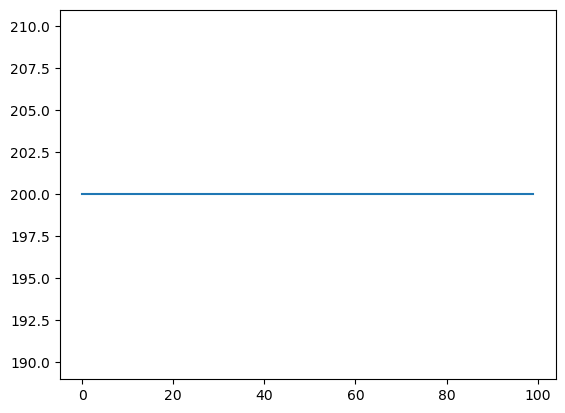

In [9]:
randomAg = randomAgent()
episodeLengths = []

for i in range(100):
    done = False
    state, _ = env.reset()
    episode_reward = 0
    env.render()
    episodeLength = 0
    while not done:
        action = randomAg.select_action(state)
        next_state, reward, terimnated, truncated, _ = env.step(action)

        episode_reward += reward

        state = next_state
        done = terminated or truncated
        episodeLength += 1
        
    episodeLengths += [episodeLength]
    
plt.plot(episodeLengths)
plt.show()

In [9]:
def round_nearest(x, a):
    return round(x / a) * a

class dynaAgent():
    def __init__(self, discr_step, γ, e, k):
        self.discr_step = discr_step
        self.γ = γ
        self.e = e
        self.k = k
        
        P = dict()
        R = dict()
        Q = dict()
        
        listOfState = []
        minX = round_nearest(env.observation_space.low[0], discr_step[0])
        maxX = round_nearest(env.observation_space.high[0], discr_step[0])
        minVel = round_nearest(env.observation_space.low[1], discr_step[1])
        maxVel = round_nearest(env.observation_space.high[1], discr_step[1])
        
        for x in np.arange(minX, maxX+discr_step[0], discr_step[0]):
            for vel in np.arange(minVel, maxVel+discr_step[1], discr_step[1]):
                listOfState.append([round(x,5), round(vel,5)])
        
        listOfAction = []
        for action in np.arange(env.action_space.start, env.action_space.start + env.action_space.n):
            listOfAction += [action]
                
        #prob = 1.0/len(listOfState)
        for stateIni in listOfState:
            for action in listOfAction:
                R[(stateIni[0], stateIni[1], action)] = 0
                Q[(stateIni[0], stateIni[1], action)] = 0
                #for stateFin in listOfState:
                    #P[(stateIni[0], stateIni[1], action, stateFin[0], stateFin[1])] = prob
                
        self.P = P
        self.R = R
        self.Q = Q
        self.P_opti = dict()

        self.listOfState = listOfState
        self.listOfAction = listOfAction
        
    def observe(self, state, action, next_state, reward):
        #t_start = time.time()
        #called upon observing a new transition of the environment.
        stateIni = [0,0]
        stateIni[0] = round(round_nearest(state[0], self.discr_step[0]),5)
        stateIni[1] = round(round_nearest(state[1], self.discr_step[1]),5)
        
        stateFin = [0,0]
        stateFin[0] = round(round_nearest(next_state[0], self.discr_step[0]),5)
        stateFin[1] = round(round_nearest(next_state[1], self.discr_step[1]),5)
        
        currentDict = self.P.get((stateIni[0], stateIni[1], action), {str(stateFin): [stateFin, 0], "total": 0})
        newState = currentDict.get(str(stateFin), [stateFin, 0])
        currentDict[str(stateFin)] = [newState[0], newState[1] + 1]
        currentDict["total"] += 1
        self.P[(stateIni[0], stateIni[1], action)] = currentDict
            
        self.P_opti[(stateIni[0], stateIni[1], action)] = 1
        
        self.R[(stateIni[0], stateIni[1], action)] = reward
        sumOfProb = 0
        
        
        for n, v in self.P[(stateIni[0], stateIni[1], action)].items():
            if n == "total":
                continue
                
            stateIter = v[0]
                
            maxElem = self.Q[(stateIter[0], stateIter[1], self.listOfAction[0])]
            for actionIter in self.listOfAction[1:]:
                elem = self.Q[(stateIter[0], stateIter[1], actionIter)]
                if elem > maxElem:
                    maxElem = elem
            sumOfProb += self.P[(stateIni[0], stateIni[1], action)][str(stateIter)][1]/self.P[(stateIni[0], stateIni[1], action)]["total"] * maxElem
        
        changeReward = (reward + self.γ * sumOfProb) - self.Q[(stateIni[0], stateIni[1], action)]
        self.Q[(stateIni[0], stateIni[1], action)] = reward + self.γ * sumOfProb
        #t_end = time.time()
        returnMean = self.update()
        returnMean = (changeReward + returnMean)/(self.k)
        self.e[0] = max([self.e[0] * 0.9998, self.e[1]])
        
        #print("observedTime = " + str(t_end-t_start))
        return abs(returnMean)
        
    def select_action(self, state): 
        #t_start = time.time()
        #pick an action from the given state.
        p = random.random()
        
        if (p < self.e[0]):
            #t_end = time.time()
            #print("selectTime = " + str(t_end-t_start))
            return env.action_space.sample()
        else:
            stateRounded = [0,0]
            stateRounded[0] = round(round_nearest(state[0], self.discr_step[0]), 5)
            stateRounded[1] = round(round_nearest(state[1], self.discr_step[1]), 5)
            bestAction = self.listOfAction[0]
            for action in self.listOfAction[1:]:
                if (self.Q[(stateRounded[0], stateRounded[1], action)] >= self.Q[(stateRounded[0], stateRounded[1], bestAction)]):
                    bestAction = action
            #t_end = time.time()
            #print("selectTime = " + str(t_end-t_start))

            return bestAction
        
    def update(self):
        #t_start = time.time()
        elemsSeen = list(self.P_opti.items())
        changeReward = 0
        
        for i in range(self.k):
            testState = [0,0]
            (testState[0], testState[1], testAction), _ = random.choice(elemsSeen)            
            
            sumOfProb = 0
            
            for n, v in self.P[(testState[0], testState[1], testAction)].items():
                if n == "total":
                    continue
                
                stateIter = v[0]
                
                maxElem = self.Q[(stateIter[0], stateIter[1], self.listOfAction[0])]
                for actionIter in self.listOfAction[1:]:
                    elem = self.Q[(stateIter[0], stateIter[1], actionIter)]
                    if elem > maxElem:
                        maxElem = elem
                sumOfProb += self.P[(testState[0], testState[1], testAction)][str(stateIter)][1]/self.P[(testState[0], testState[1], testAction)]["total"] * maxElem
            
            changeReward += (self.R[(testState[0], testState[1], testAction)] + self.γ * sumOfProb) - self.Q[(testState[0], testState[1], testAction)]
            self.Q[(testState[0], testState[1], testAction)] = self.R[(testState[0], testState[1], testAction)] + self.γ * sumOfProb
        #t_end = time.time()
        #print("updateTime = " + str(t_end-t_start))
        return changeReward

Episode  0 score: 200.00 average score: 200.00 epsilon: 0.86
Episode  1 score: 200.00 average score: 200.00 epsilon: 0.83
Episode  2 score: 200.00 average score: 200.00 epsilon: 0.80
Episode  3 score: 200.00 average score: 200.00 epsilon: 0.77
Episode  4 score: 200.00 average score: 200.00 epsilon: 0.74
Episode  5 score: 200.00 average score: 200.00 epsilon: 0.71
Episode  6 score: 200.00 average score: 200.00 epsilon: 0.68
Episode  7 score: 200.00 average score: 200.00 epsilon: 0.65
Episode  8 score: 200.00 average score: 200.00 epsilon: 0.63
Episode  9 score: 200.00 average score: 200.00 epsilon: 0.60
Episode  10 score: 200.00 average score: 200.00 epsilon: 0.58
Episode  11 score: 200.00 average score: 200.00 epsilon: 0.56
Episode  12 score: 200.00 average score: 200.00 epsilon: 0.54
Episode  13 score: 200.00 average score: 200.00 epsilon: 0.51
Episode  14 score: 200.00 average score: 200.00 epsilon: 0.49
Episode  15 score: 200.00 average score: 200.00 epsilon: 0.47
Episode  16 score:

Episode  132 score: 182.00 average score: 186.49 epsilon: 0.05
Episode  133 score: 174.00 average score: 186.23 epsilon: 0.05
Episode  134 score: 192.00 average score: 186.15 epsilon: 0.05
Episode  135 score: 159.00 average score: 185.74 epsilon: 0.05
Episode  136 score: 200.00 average score: 185.74 epsilon: 0.05
Episode  137 score: 159.00 average score: 185.33 epsilon: 0.05
Episode  138 score: 194.00 average score: 185.27 epsilon: 0.05
Episode  139 score: 197.00 average score: 185.24 epsilon: 0.05
Episode  140 score: 161.00 average score: 184.85 epsilon: 0.05
Episode  141 score: 196.00 average score: 185.28 epsilon: 0.05
Episode  142 score: 167.00 average score: 184.95 epsilon: 0.05
Episode  143 score: 160.00 average score: 184.55 epsilon: 0.05
Episode  144 score: 195.00 average score: 184.50 epsilon: 0.05
Episode  145 score: 166.00 average score: 184.16 epsilon: 0.05
Episode  146 score: 162.00 average score: 183.78 epsilon: 0.05
Episode  147 score: 193.00 average score: 183.71 epsilo

Episode  263 score: 164.00 average score: 166.90 epsilon: 0.05
Episode  264 score: 162.00 average score: 166.98 epsilon: 0.05
Episode  265 score: 147.00 average score: 166.92 epsilon: 0.05
Episode  266 score: 153.00 average score: 166.89 epsilon: 0.05
Episode  267 score: 152.00 average score: 166.77 epsilon: 0.05
Episode  268 score: 119.00 average score: 166.35 epsilon: 0.05
Episode  269 score: 150.00 average score: 166.25 epsilon: 0.05
Episode  270 score: 160.00 average score: 165.89 epsilon: 0.05
Episode  271 score: 191.00 average score: 166.40 epsilon: 0.05
Episode  272 score: 197.00 average score: 166.47 epsilon: 0.05
Episode  273 score: 196.00 average score: 166.85 epsilon: 0.05
Episode  274 score: 168.00 average score: 166.94 epsilon: 0.05
Episode  275 score: 152.00 average score: 166.74 epsilon: 0.05
Episode  276 score: 186.00 average score: 166.70 epsilon: 0.05
Episode  277 score: 168.00 average score: 166.65 epsilon: 0.05
Episode  278 score: 153.00 average score: 166.66 epsilo

Episode  394 score: 150.00 average score: 164.73 epsilon: 0.05
Episode  395 score: 150.00 average score: 164.65 epsilon: 0.05
Episode  396 score: 183.00 average score: 164.92 epsilon: 0.05
Episode  397 score: 148.00 average score: 164.91 epsilon: 0.05
Episode  398 score: 169.00 average score: 164.69 epsilon: 0.05
Episode  399 score: 168.00 average score: 164.47 epsilon: 0.05
Episode  400 score: 167.00 average score: 164.16 epsilon: 0.05
Episode  401 score: 154.00 average score: 163.70 epsilon: 0.05
Episode  402 score: 151.00 average score: 163.70 epsilon: 0.05
Episode  403 score: 154.00 average score: 163.66 epsilon: 0.05
Episode  404 score: 171.00 average score: 163.85 epsilon: 0.05
Episode  405 score: 152.00 average score: 163.85 epsilon: 0.05
Episode  406 score: 184.00 average score: 163.83 epsilon: 0.05
Episode  407 score: 152.00 average score: 163.80 epsilon: 0.05
Episode  408 score: 168.00 average score: 163.98 epsilon: 0.05
Episode  409 score: 192.00 average score: 164.23 epsilo

Episode  525 score: 150.00 average score: 159.54 epsilon: 0.05
Episode  526 score: 119.00 average score: 159.24 epsilon: 0.05
Episode  527 score: 161.00 average score: 159.28 epsilon: 0.05
Episode  528 score: 150.00 average score: 159.25 epsilon: 0.05
Episode  529 score: 154.00 average score: 158.86 epsilon: 0.05
Episode  530 score: 153.00 average score: 158.88 epsilon: 0.05
Episode  531 score: 150.00 average score: 158.89 epsilon: 0.05
Episode  532 score: 148.00 average score: 158.79 epsilon: 0.05
Episode  533 score: 149.00 average score: 158.77 epsilon: 0.05
Episode  534 score: 152.00 average score: 158.73 epsilon: 0.05
Episode  535 score: 148.00 average score: 158.26 epsilon: 0.05
Episode  536 score: 166.00 average score: 158.41 epsilon: 0.05
Episode  537 score: 153.00 average score: 158.48 epsilon: 0.05
Episode  538 score: 200.00 average score: 158.58 epsilon: 0.05
Episode  539 score: 147.00 average score: 158.57 epsilon: 0.05
Episode  540 score: 123.00 average score: 158.30 epsilo

Episode  656 score: 152.00 average score: 151.57 epsilon: 0.05
Episode  657 score: 152.00 average score: 151.52 epsilon: 0.05
Episode  658 score: 159.00 average score: 151.62 epsilon: 0.05
Episode  659 score: 150.00 average score: 151.25 epsilon: 0.05
Episode  660 score: 115.00 average score: 150.59 epsilon: 0.05
Episode  661 score: 146.00 average score: 150.50 epsilon: 0.05
Episode  662 score: 144.00 average score: 150.47 epsilon: 0.05
Episode  663 score: 152.00 average score: 150.47 epsilon: 0.05
Episode  664 score: 156.00 average score: 150.54 epsilon: 0.05
Episode  665 score: 150.00 average score: 150.07 epsilon: 0.05
Episode  666 score: 175.00 average score: 150.30 epsilon: 0.05
Episode  667 score: 116.00 average score: 149.46 epsilon: 0.05
Episode  668 score: 142.00 average score: 149.01 epsilon: 0.05
Episode  669 score: 151.00 average score: 149.05 epsilon: 0.05
Episode  670 score: 119.00 average score: 148.74 epsilon: 0.05
Episode  671 score: 147.00 average score: 148.78 epsilo

Episode  787 score: 160.00 average score: 152.10 epsilon: 0.05
Episode  788 score: 145.00 average score: 151.56 epsilon: 0.05
Episode  789 score: 200.00 average score: 152.11 epsilon: 0.05
Episode  790 score: 149.00 average score: 152.47 epsilon: 0.05
Episode  791 score: 150.00 average score: 152.47 epsilon: 0.05
Episode  792 score: 149.00 average score: 152.37 epsilon: 0.05
Episode  793 score: 147.00 average score: 151.84 epsilon: 0.05
Episode  794 score: 146.00 average score: 152.15 epsilon: 0.05
Episode  795 score: 151.00 average score: 152.52 epsilon: 0.05
Episode  796 score: 151.00 average score: 152.12 epsilon: 0.05
Episode  797 score: 151.00 average score: 151.93 epsilon: 0.05
Episode  798 score: 145.00 average score: 151.95 epsilon: 0.05
Episode  799 score: 114.00 average score: 151.93 epsilon: 0.05
Episode  800 score: 116.00 average score: 151.94 epsilon: 0.05
Episode  801 score: 147.00 average score: 151.83 epsilon: 0.05
Episode  802 score: 150.00 average score: 151.86 epsilo

Episode  918 score: 196.00 average score: 151.35 epsilon: 0.05
Episode  919 score: 199.00 average score: 151.79 epsilon: 0.05
Episode  920 score: 156.00 average score: 152.20 epsilon: 0.05
Episode  921 score: 117.00 average score: 151.85 epsilon: 0.05
Episode  922 score: 113.00 average score: 151.47 epsilon: 0.05
Episode  923 score: 112.00 average score: 151.05 epsilon: 0.05
Episode  924 score: 155.00 average score: 151.05 epsilon: 0.05
Episode  925 score: 157.00 average score: 151.12 epsilon: 0.05
Episode  926 score: 156.00 average score: 150.83 epsilon: 0.05
Episode  927 score: 142.00 average score: 150.76 epsilon: 0.05
Episode  928 score: 200.00 average score: 150.79 epsilon: 0.05
Episode  929 score: 139.00 average score: 150.74 epsilon: 0.05
Episode  930 score: 155.00 average score: 150.43 epsilon: 0.05
Episode  931 score: 111.00 average score: 149.84 epsilon: 0.05
Episode  932 score: 146.00 average score: 150.17 epsilon: 0.05
Episode  933 score: 140.00 average score: 150.15 epsilo

Episode  1048 score: 150.00 average score: 143.44 epsilon: 0.05
Episode  1049 score: 144.00 average score: 143.42 epsilon: 0.05
Episode  1050 score: 148.00 average score: 143.40 epsilon: 0.05
Episode  1051 score: 150.00 average score: 143.75 epsilon: 0.05
Episode  1052 score: 114.00 average score: 143.40 epsilon: 0.05
Episode  1053 score: 146.00 average score: 143.71 epsilon: 0.05
Episode  1054 score: 151.00 average score: 143.97 epsilon: 0.05
Episode  1055 score: 147.00 average score: 144.30 epsilon: 0.05
Episode  1056 score: 146.00 average score: 144.61 epsilon: 0.05
Episode  1057 score: 151.00 average score: 144.67 epsilon: 0.05
Episode  1058 score: 137.00 average score: 144.40 epsilon: 0.05
Episode  1059 score: 144.00 average score: 144.41 epsilon: 0.05
Episode  1060 score: 144.00 average score: 144.37 epsilon: 0.05
Episode  1061 score: 157.00 average score: 144.76 epsilon: 0.05
Episode  1062 score: 106.00 average score: 144.13 epsilon: 0.05
Episode  1063 score: 148.00 average scor

Episode  1177 score: 148.00 average score: 139.74 epsilon: 0.05
Episode  1178 score: 143.00 average score: 139.55 epsilon: 0.05
Episode  1179 score: 151.00 average score: 139.58 epsilon: 0.05
Episode  1180 score: 141.00 average score: 139.87 epsilon: 0.05
Episode  1181 score: 153.00 average score: 139.89 epsilon: 0.05
Episode  1182 score: 104.00 average score: 139.41 epsilon: 0.05
Episode  1183 score: 129.00 average score: 139.22 epsilon: 0.05
Episode  1184 score: 146.00 average score: 139.28 epsilon: 0.05
Episode  1185 score: 112.00 average score: 139.25 epsilon: 0.05
Episode  1186 score: 141.00 average score: 139.51 epsilon: 0.05
Episode  1187 score: 105.00 average score: 138.72 epsilon: 0.05
Episode  1188 score: 144.00 average score: 139.14 epsilon: 0.05
Episode  1189 score: 147.00 average score: 139.07 epsilon: 0.05
Episode  1190 score: 146.00 average score: 139.39 epsilon: 0.05
Episode  1191 score: 133.00 average score: 139.61 epsilon: 0.05
Episode  1192 score: 144.00 average scor

Episode  1306 score: 147.00 average score: 135.80 epsilon: 0.05
Episode  1307 score: 157.00 average score: 136.27 epsilon: 0.05
Episode  1308 score: 160.00 average score: 136.43 epsilon: 0.05
Episode  1309 score: 150.00 average score: 136.47 epsilon: 0.05
Episode  1310 score: 138.00 average score: 136.37 epsilon: 0.05
Episode  1311 score: 146.00 average score: 136.34 epsilon: 0.05
Episode  1312 score: 144.00 average score: 136.41 epsilon: 0.05
Episode  1313 score: 142.00 average score: 136.67 epsilon: 0.05
Episode  1314 score: 108.00 average score: 136.14 epsilon: 0.05
Episode  1315 score: 179.00 average score: 136.81 epsilon: 0.05
Episode  1316 score: 140.00 average score: 136.77 epsilon: 0.05
Episode  1317 score: 144.00 average score: 137.10 epsilon: 0.05
Episode  1318 score: 103.00 average score: 136.65 epsilon: 0.05
Episode  1319 score: 143.00 average score: 136.61 epsilon: 0.05
Episode  1320 score: 145.00 average score: 136.60 epsilon: 0.05
Episode  1321 score: 111.00 average scor

Episode  1435 score: 143.00 average score: 135.21 epsilon: 0.05
Episode  1436 score: 113.00 average score: 135.16 epsilon: 0.05
Episode  1437 score: 156.00 average score: 135.40 epsilon: 0.05
Episode  1438 score: 155.00 average score: 135.46 epsilon: 0.05
Episode  1439 score: 121.00 average score: 135.78 epsilon: 0.05
Episode  1440 score: 110.00 average score: 135.39 epsilon: 0.05
Episode  1441 score: 122.00 average score: 135.10 epsilon: 0.05
Episode  1442 score: 147.00 average score: 135.55 epsilon: 0.05
Episode  1443 score: 147.00 average score: 135.45 epsilon: 0.05
Episode  1444 score: 196.00 average score: 136.01 epsilon: 0.05
Episode  1445 score: 139.00 average score: 136.37 epsilon: 0.05
Episode  1446 score: 146.00 average score: 136.36 epsilon: 0.05
Episode  1447 score: 143.00 average score: 136.48 epsilon: 0.05
Episode  1448 score: 119.00 average score: 136.26 epsilon: 0.05
Episode  1449 score: 103.00 average score: 136.20 epsilon: 0.05
Episode  1450 score: 194.00 average scor

Episode  1564 score: 148.00 average score: 136.19 epsilon: 0.05
Episode  1565 score: 199.00 average score: 136.73 epsilon: 0.05
Episode  1566 score: 130.00 average score: 136.56 epsilon: 0.05
Episode  1567 score: 159.00 average score: 136.57 epsilon: 0.05
Episode  1568 score: 150.00 average score: 136.86 epsilon: 0.05
Episode  1569 score: 152.00 average score: 137.19 epsilon: 0.05
Episode  1570 score: 113.00 average score: 137.04 epsilon: 0.05
Episode  1571 score: 111.00 average score: 136.63 epsilon: 0.05
Episode  1572 score: 144.00 average score: 136.67 epsilon: 0.05
Episode  1573 score: 89.00 average score: 136.06 epsilon: 0.05
Episode  1574 score: 145.00 average score: 136.40 epsilon: 0.05
Episode  1575 score: 148.00 average score: 136.67 epsilon: 0.05
Episode  1576 score: 147.00 average score: 136.65 epsilon: 0.05
Episode  1577 score: 157.00 average score: 137.23 epsilon: 0.05
Episode  1578 score: 149.00 average score: 137.07 epsilon: 0.05
Episode  1579 score: 116.00 average score

Episode  1693 score: 160.00 average score: 136.60 epsilon: 0.05
Episode  1694 score: 141.00 average score: 136.88 epsilon: 0.05
Episode  1695 score: 109.00 average score: 136.73 epsilon: 0.05
Episode  1696 score: 156.00 average score: 136.74 epsilon: 0.05
Episode  1697 score: 150.00 average score: 136.75 epsilon: 0.05
Episode  1698 score: 137.00 average score: 136.66 epsilon: 0.05
Episode  1699 score: 110.00 average score: 136.15 epsilon: 0.05
Episode  1700 score: 185.00 average score: 136.56 epsilon: 0.05
Episode  1701 score: 143.00 average score: 136.58 epsilon: 0.05
Episode  1702 score: 157.00 average score: 136.67 epsilon: 0.05
Episode  1703 score: 144.00 average score: 136.98 epsilon: 0.05
Episode  1704 score: 149.00 average score: 137.56 epsilon: 0.05
Episode  1705 score: 114.00 average score: 137.22 epsilon: 0.05
Episode  1706 score: 159.00 average score: 137.35 epsilon: 0.05
Episode  1707 score: 101.00 average score: 136.89 epsilon: 0.05
Episode  1708 score: 150.00 average scor

Episode  1822 score: 151.00 average score: 134.83 epsilon: 0.05
Episode  1823 score: 112.00 average score: 134.83 epsilon: 0.05
Episode  1824 score: 103.00 average score: 134.76 epsilon: 0.05
Episode  1825 score: 146.00 average score: 134.90 epsilon: 0.05
Episode  1826 score: 142.00 average score: 135.21 epsilon: 0.05
Episode  1827 score: 147.00 average score: 135.58 epsilon: 0.05
Episode  1828 score: 113.00 average score: 135.27 epsilon: 0.05
Episode  1829 score: 148.00 average score: 135.17 epsilon: 0.05
Episode  1830 score: 114.00 average score: 134.93 epsilon: 0.05
Episode  1831 score: 152.00 average score: 135.27 epsilon: 0.05
Episode  1832 score: 138.00 average score: 135.53 epsilon: 0.05
Episode  1833 score: 91.00 average score: 135.33 epsilon: 0.05
Episode  1834 score: 110.00 average score: 135.33 epsilon: 0.05
Episode  1835 score: 145.00 average score: 135.33 epsilon: 0.05
Episode  1836 score: 102.00 average score: 135.25 epsilon: 0.05
Episode  1837 score: 147.00 average score

Episode  1951 score: 160.00 average score: 133.89 epsilon: 0.05
Episode  1952 score: 113.00 average score: 133.76 epsilon: 0.05
Episode  1953 score: 180.00 average score: 134.06 epsilon: 0.05
Episode  1954 score: 144.00 average score: 134.10 epsilon: 0.05
Episode  1955 score: 110.00 average score: 133.79 epsilon: 0.05
Episode  1956 score: 114.00 average score: 133.35 epsilon: 0.05
Episode  1957 score: 112.00 average score: 132.89 epsilon: 0.05
Episode  1958 score: 145.00 average score: 132.89 epsilon: 0.05
Episode  1959 score: 148.00 average score: 133.24 epsilon: 0.05
Episode  1960 score: 187.00 average score: 134.06 epsilon: 0.05
Episode  1961 score: 145.00 average score: 134.36 epsilon: 0.05
Episode  1962 score: 145.00 average score: 134.60 epsilon: 0.05
Episode  1963 score: 112.00 average score: 134.27 epsilon: 0.05
Episode  1964 score: 149.00 average score: 134.47 epsilon: 0.05
Episode  1965 score: 147.00 average score: 134.92 epsilon: 0.05
Episode  1966 score: 144.00 average scor

Episode  2080 score: 145.00 average score: 136.80 epsilon: 0.05
Episode  2081 score: 110.00 average score: 136.44 epsilon: 0.05
Episode  2082 score: 155.00 average score: 136.49 epsilon: 0.05
Episode  2083 score: 113.00 average score: 136.30 epsilon: 0.05
Episode  2084 score: 114.00 average score: 135.89 epsilon: 0.05
Episode  2085 score: 170.00 average score: 136.12 epsilon: 0.05
Episode  2086 score: 110.00 average score: 136.06 epsilon: 0.05
Episode  2087 score: 154.00 average score: 136.15 epsilon: 0.05
Episode  2088 score: 145.00 average score: 136.10 epsilon: 0.05
Episode  2089 score: 115.00 average score: 135.75 epsilon: 0.05
Episode  2090 score: 133.00 average score: 135.94 epsilon: 0.05
Episode  2091 score: 145.00 average score: 135.91 epsilon: 0.05
Episode  2092 score: 111.00 average score: 135.53 epsilon: 0.05
Episode  2093 score: 146.00 average score: 135.52 epsilon: 0.05
Episode  2094 score: 148.00 average score: 135.51 epsilon: 0.05
Episode  2095 score: 148.00 average scor

Episode  2209 score: 149.00 average score: 140.90 epsilon: 0.05
Episode  2210 score: 103.00 average score: 140.77 epsilon: 0.05
Episode  2211 score: 111.00 average score: 140.42 epsilon: 0.05
Episode  2212 score: 146.00 average score: 140.37 epsilon: 0.05
Episode  2213 score: 120.00 average score: 140.05 epsilon: 0.05
Episode  2214 score: 145.00 average score: 140.04 epsilon: 0.05
Episode  2215 score: 96.00 average score: 139.53 epsilon: 0.05
Episode  2216 score: 152.00 average score: 139.58 epsilon: 0.05
Episode  2217 score: 116.00 average score: 139.56 epsilon: 0.05
Episode  2218 score: 145.00 average score: 140.09 epsilon: 0.05
Episode  2219 score: 107.00 average score: 139.55 epsilon: 0.05
Episode  2220 score: 143.00 average score: 139.53 epsilon: 0.05
Episode  2221 score: 157.00 average score: 139.66 epsilon: 0.05
Episode  2222 score: 114.00 average score: 139.71 epsilon: 0.05
Episode  2223 score: 103.00 average score: 139.65 epsilon: 0.05
Episode  2224 score: 148.00 average score

Episode  2338 score: 145.00 average score: 141.14 epsilon: 0.05
Episode  2339 score: 111.00 average score: 141.34 epsilon: 0.05
Episode  2340 score: 148.00 average score: 141.72 epsilon: 0.05
Episode  2341 score: 142.00 average score: 141.63 epsilon: 0.05
Episode  2342 score: 111.00 average score: 141.16 epsilon: 0.05
Episode  2343 score: 139.00 average score: 141.00 epsilon: 0.05
Episode  2344 score: 109.00 average score: 140.59 epsilon: 0.05
Episode  2345 score: 200.00 average score: 141.48 epsilon: 0.05
Episode  2346 score: 110.00 average score: 141.10 epsilon: 0.05
Episode  2347 score: 148.00 average score: 140.99 epsilon: 0.05
Episode  2348 score: 144.00 average score: 141.48 epsilon: 0.05
Episode  2349 score: 156.00 average score: 141.92 epsilon: 0.05
Episode  2350 score: 146.00 average score: 141.93 epsilon: 0.05
Episode  2351 score: 145.00 average score: 141.94 epsilon: 0.05
Episode  2352 score: 146.00 average score: 141.95 epsilon: 0.05
Episode  2353 score: 108.00 average scor

Episode  2467 score: 155.00 average score: 145.10 epsilon: 0.05
Episode  2468 score: 157.00 average score: 145.17 epsilon: 0.05
Episode  2469 score: 164.00 average score: 145.71 epsilon: 0.05
Episode  2470 score: 146.00 average score: 145.65 epsilon: 0.05
Episode  2471 score: 200.00 average score: 146.16 epsilon: 0.05
Episode  2472 score: 108.00 average score: 145.73 epsilon: 0.05
Episode  2473 score: 149.00 average score: 145.71 epsilon: 0.05
Episode  2474 score: 156.00 average score: 145.64 epsilon: 0.05
Episode  2475 score: 148.00 average score: 146.02 epsilon: 0.05
Episode  2476 score: 147.00 average score: 146.01 epsilon: 0.05
Episode  2477 score: 142.00 average score: 145.95 epsilon: 0.05
Episode  2478 score: 113.00 average score: 145.60 epsilon: 0.05
Episode  2479 score: 140.00 average score: 145.51 epsilon: 0.05
Episode  2480 score: 138.00 average score: 145.78 epsilon: 0.05
Episode  2481 score: 147.00 average score: 145.72 epsilon: 0.05
Episode  2482 score: 147.00 average scor

Episode  2596 score: 110.00 average score: 140.01 epsilon: 0.05
Episode  2597 score: 148.00 average score: 140.03 epsilon: 0.05
Episode  2598 score: 158.00 average score: 140.21 epsilon: 0.05
Episode  2599 score: 149.00 average score: 140.28 epsilon: 0.05
Episode  2600 score: 138.00 average score: 140.20 epsilon: 0.05
Episode  2601 score: 145.00 average score: 140.16 epsilon: 0.05
Episode  2602 score: 143.00 average score: 140.50 epsilon: 0.05
Episode  2603 score: 152.00 average score: 140.99 epsilon: 0.05
Episode  2604 score: 149.00 average score: 141.11 epsilon: 0.05
Episode  2605 score: 103.00 average score: 140.73 epsilon: 0.05
Episode  2606 score: 112.00 average score: 140.39 epsilon: 0.05
Episode  2607 score: 152.00 average score: 140.84 epsilon: 0.05
Episode  2608 score: 107.00 average score: 140.42 epsilon: 0.05
Episode  2609 score: 145.00 average score: 140.34 epsilon: 0.05
Episode  2610 score: 146.00 average score: 140.38 epsilon: 0.05
Episode  2611 score: 158.00 average scor

Episode  2725 score: 148.00 average score: 138.22 epsilon: 0.05
Episode  2726 score: 147.00 average score: 138.39 epsilon: 0.05
Episode  2727 score: 141.00 average score: 138.42 epsilon: 0.05
Episode  2728 score: 147.00 average score: 138.99 epsilon: 0.05
Episode  2729 score: 149.00 average score: 138.94 epsilon: 0.05
Episode  2730 score: 93.00 average score: 138.40 epsilon: 0.05
Episode  2731 score: 145.00 average score: 138.83 epsilon: 0.05
Episode  2732 score: 160.00 average score: 138.93 epsilon: 0.05
Episode  2733 score: 143.00 average score: 138.86 epsilon: 0.05
Episode  2734 score: 150.00 average score: 138.76 epsilon: 0.05
Episode  2735 score: 143.00 average score: 138.67 epsilon: 0.05
Episode  2736 score: 145.00 average score: 138.66 epsilon: 0.05
Episode  2737 score: 146.00 average score: 138.58 epsilon: 0.05
Episode  2738 score: 149.00 average score: 138.53 epsilon: 0.05
Episode  2739 score: 148.00 average score: 138.46 epsilon: 0.05
Episode  2740 score: 97.00 average score:

Episode  2854 score: 111.00 average score: 134.99 epsilon: 0.05
Episode  2855 score: 144.00 average score: 134.91 epsilon: 0.05
Episode  2856 score: 144.00 average score: 134.86 epsilon: 0.05
Episode  2857 score: 155.00 average score: 135.21 epsilon: 0.05
Episode  2858 score: 108.00 average score: 134.73 epsilon: 0.05
Episode  2859 score: 153.00 average score: 135.13 epsilon: 0.05
Episode  2860 score: 147.00 average score: 135.49 epsilon: 0.05
Episode  2861 score: 152.00 average score: 135.42 epsilon: 0.05
Episode  2862 score: 147.00 average score: 135.38 epsilon: 0.05
Episode  2863 score: 159.00 average score: 135.92 epsilon: 0.05
Episode  2864 score: 148.00 average score: 136.02 epsilon: 0.05
Episode  2865 score: 146.00 average score: 136.36 epsilon: 0.05
Episode  2866 score: 145.00 average score: 136.36 epsilon: 0.05
Episode  2867 score: 152.00 average score: 136.40 epsilon: 0.05
Episode  2868 score: 148.00 average score: 136.41 epsilon: 0.05
Episode  2869 score: 151.00 average scor

Episode  2983 score: 120.00 average score: 138.94 epsilon: 0.05
Episode  2984 score: 102.00 average score: 138.46 epsilon: 0.05
Episode  2985 score: 156.00 average score: 138.02 epsilon: 0.05
Episode  2986 score: 116.00 average score: 137.69 epsilon: 0.05
Episode  2987 score: 147.00 average score: 137.71 epsilon: 0.05
Episode  2988 score: 151.00 average score: 137.65 epsilon: 0.05
Episode  2989 score: 92.00 average score: 137.64 epsilon: 0.05
Episode  2990 score: 145.00 average score: 137.67 epsilon: 0.05
Episode  2991 score: 147.00 average score: 138.07 epsilon: 0.05
Episode  2992 score: 156.00 average score: 138.17 epsilon: 0.05
Episode  2993 score: 108.00 average score: 137.77 epsilon: 0.05
Episode  2994 score: 146.00 average score: 137.74 epsilon: 0.05
Episode  2995 score: 154.00 average score: 138.19 epsilon: 0.05
Episode  2996 score: 156.00 average score: 138.35 epsilon: 0.05
Episode  2997 score: 151.00 average score: 138.34 epsilon: 0.05
Episode  2998 score: 144.00 average score

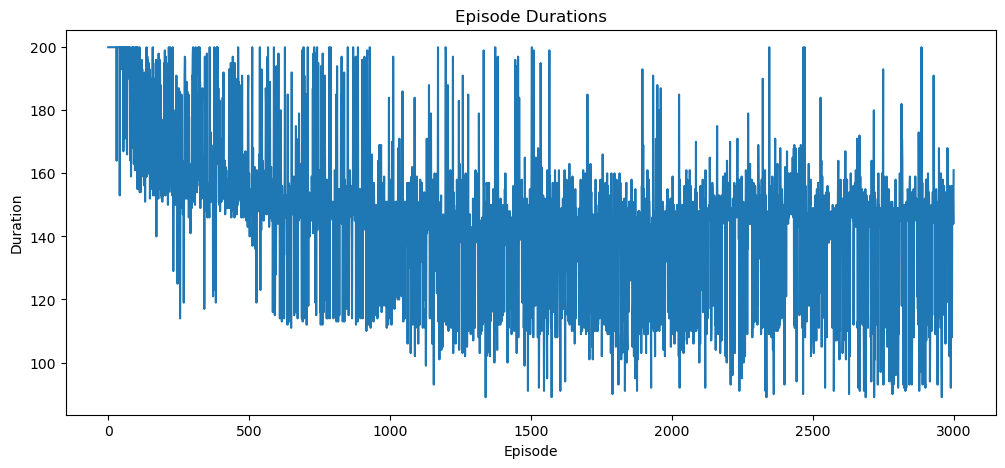

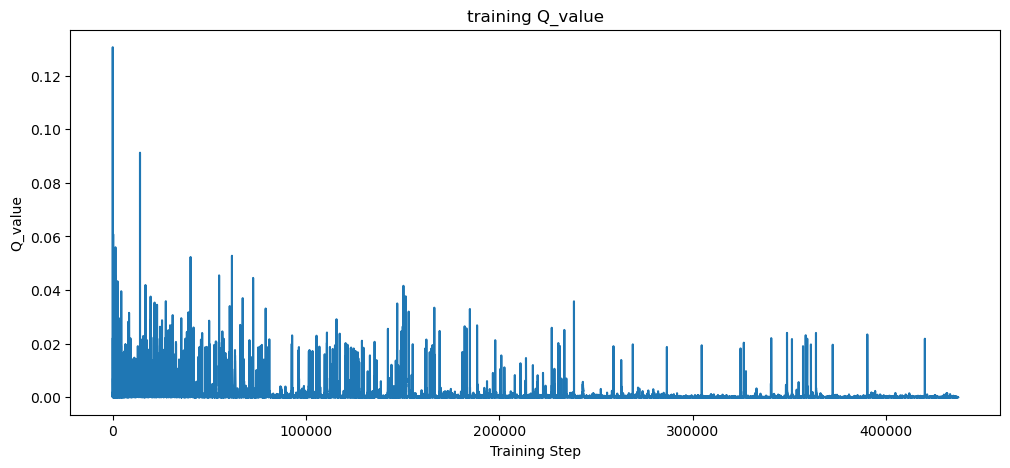

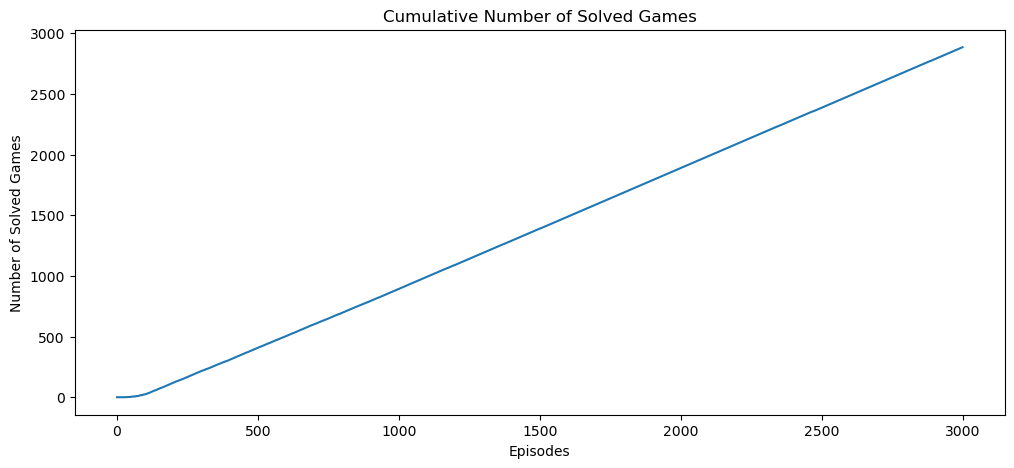

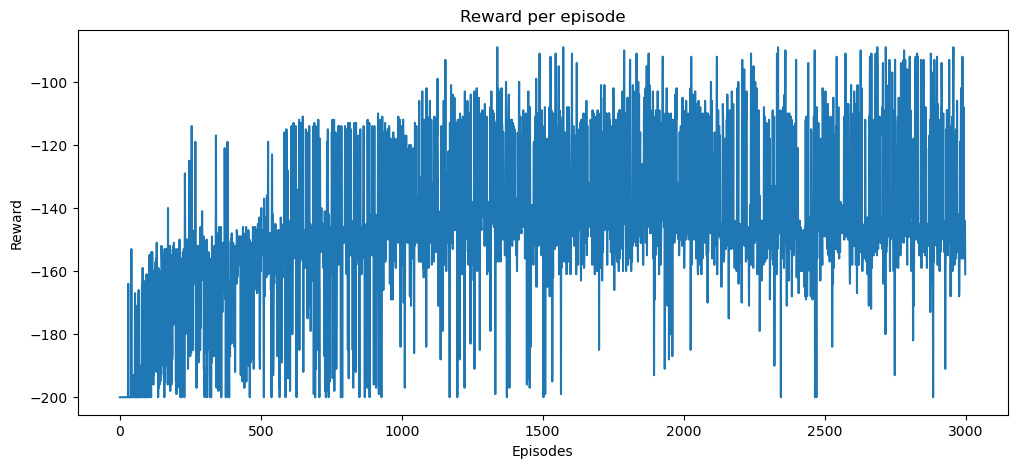

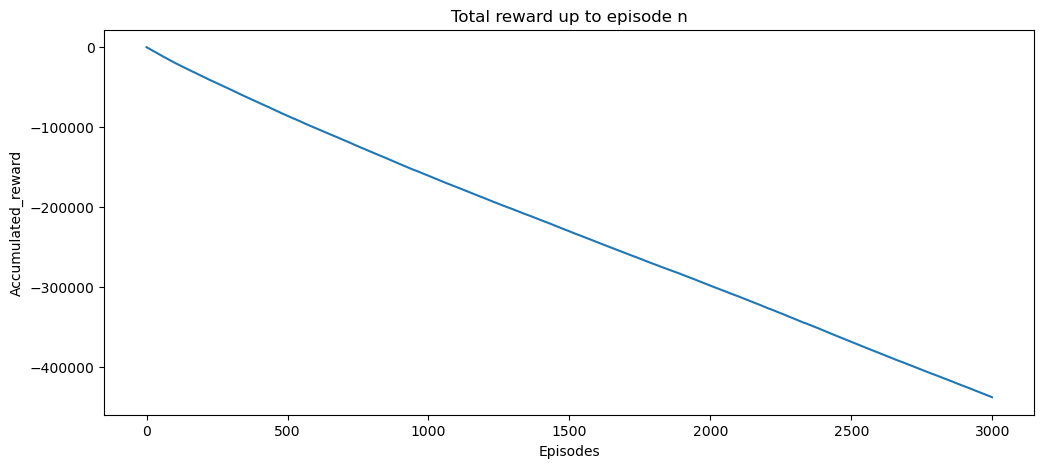

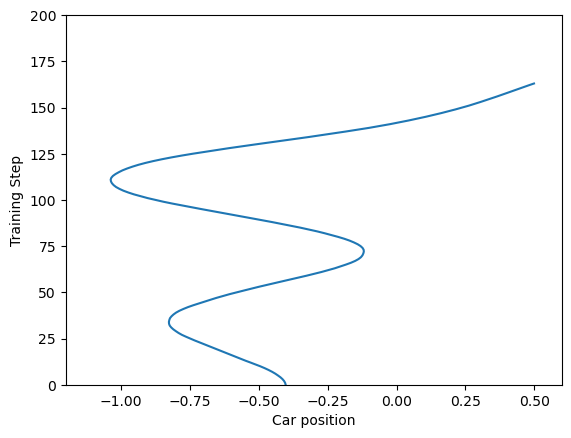

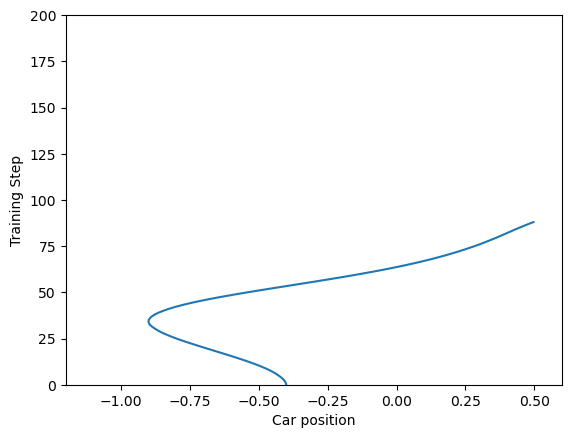

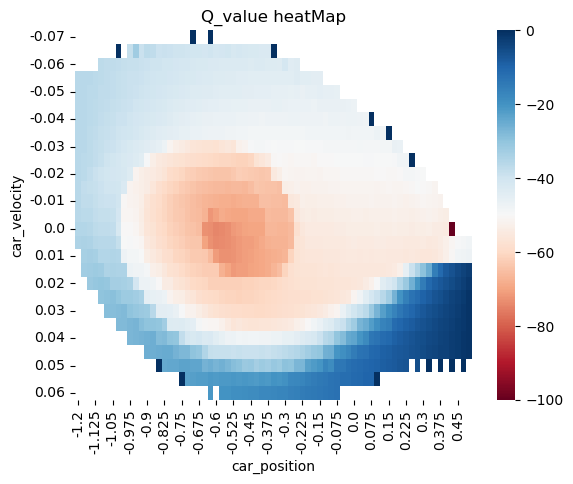

In [10]:
dynaAgSave = dynaAgent([0.025,0.0050], 0.99, [0.9, 0.05], 2000)

scores, eps_history, solved_count_history, accumulated_reward_per_ep, total_reward_up_to_n, Qval = [], [], [], [], [], []
n_games = 3000
solved_games = 0  # Counter for the number of games solved
total_reward_up_to_now = 0
imgs = [[], []]
smallest = 200

for i in range(n_games):
    steps, total_reward, done = 0, 0, False
    observation, _ = env.reset()
    imgTemp = []
    while not done:
        imgTemp += [observation[0]]
        action = dynaAgSave.select_action(observation)
        observation_, reward, terminated, truncated, _ = env.step(action)
        steps += 1
        done = terminated or truncated
        Qval += [dynaAgSave.observe(observation, action, observation_, reward)]
        observation = observation_
        total_reward += reward
        total_reward_up_to_now += reward

    scores.append(steps)
    accumulated_reward_per_ep.append(total_reward)
    total_reward_up_to_n.append(total_reward_up_to_now)
    if steps < 200:
        solved_games += 1
        if smallest == 200:
            imgs[0] = imgTemp
            smallest = steps
        if steps < smallest:
            imgs[1] = imgTemp
            smallest = steps

    solved_count_history.append(solved_games)

    avg_score = np.mean(scores[-100:])
    print('Episode ', i, 'score: %.2f' % steps, 'average score: %.2f' % avg_score, 'epsilon: %.2f' % dynaAgSave.e[0])

# Visualization of Results
plt.figure(figsize=(12, 5))
plt.plot(scores)
plt.title('Episode Durations')
plt.xlabel('Episode')
plt.ylabel('Duration')
plt.show()

plt.figure(figsize=(12, 5))
plt.plot(Qval)
plt.title('training Q_value')
plt.xlabel('Training Step')
plt.ylabel('Q_value')
plt.show()

plt.figure(figsize=(12, 5))
plt.plot(solved_count_history)
plt.title('Cumulative Number of Solved Games')
plt.xlabel('Episodes')
plt.ylabel('Number of Solved Games')
plt.show()

plt.figure(figsize=(12, 5))
plt.plot(accumulated_reward_per_ep)
plt.title('Reward per episode')
plt.xlabel('Episodes')
plt.ylabel('Reward')
plt.show()

plt.figure(figsize=(12, 5))
plt.plot(total_reward_up_to_n)
plt.title('Total reward up to episode n')
plt.xlabel('Episodes')
plt.ylabel('Accumulated_reward')
plt.show()

for img in imgs:
    ax = plt.gca()
    ax.plot(img)
    ax.set_xlim([env.observation_space.low[0], env.observation_space.high[0]])
    ax.set_ylim([0, 200])
    newx = ax.lines[0].get_ydata()
    newy = ax.lines[0].get_xdata()

    # set new x- and y- data for the line
    ax.lines[0].set_xdata(newx)
    ax.lines[0].set_ydata(newy)
    plt.ylabel('Training Step')
    plt.xlabel('Car position')
    plt.show()
    
xs = []
ys = []
Qs = []
seen = []

for k in dynaAgSave.P_opti.keys():
    if (k[0], k[1]) in seen:
        continue
        
    seen += [(k[0], k[1])]
    xs += [k[0]]
    ys += [k[1]]
    
    maxElem = dynaAgSave.Q[(k[0], k[1], dynaAgSave.listOfAction[0])]
    for actionIter in dynaAgSave.listOfAction[1:]:
        elem = dynaAgSave.Q[(k[0], k[1], actionIter)]
        if elem > maxElem:
            maxElem = elem
    Qs += [maxElem]

df = pd.DataFrame.from_dict(np.array([xs,ys,Qs]).T)
df.columns = ['car_position','car_velocity','max_Q_value']
df['Z_value'] = pd.to_numeric(df['max_Q_value'])
pivotted= df.pivot(index='car_velocity', columns='car_position', values='max_Q_value')
ax = sns.heatmap(pivotted,cmap='RdBu')
plt.title('Q_value heatMap')
plt.show()

with open('DynaModel.pkl', 'wb') as outp:
    pickle.dump(dynaAgSave, outp, pickle.HIGHEST_PROTOCOL)

Training up to 10000 episode to check the evolutions of the Q values

Episode  0 score: 141.00 average score: 141.00 epsilon: 0.05
Episode  1 score: 113.00 average score: 127.00 epsilon: 0.05
Episode  2 score: 117.00 average score: 123.67 epsilon: 0.05
Episode  3 score: 152.00 average score: 130.75 epsilon: 0.05
Episode  4 score: 147.00 average score: 134.00 epsilon: 0.05
Episode  5 score: 150.00 average score: 136.67 epsilon: 0.05
Episode  6 score: 153.00 average score: 139.00 epsilon: 0.05
Episode  7 score: 142.00 average score: 139.38 epsilon: 0.05
Episode  8 score: 115.00 average score: 136.67 epsilon: 0.05
Episode  9 score: 93.00 average score: 132.30 epsilon: 0.05
Episode  10 score: 157.00 average score: 134.55 epsilon: 0.05
Episode  11 score: 151.00 average score: 135.92 epsilon: 0.05
Episode  12 score: 162.00 average score: 137.92 epsilon: 0.05
Episode  13 score: 92.00 average score: 134.64 epsilon: 0.05
Episode  14 score: 122.00 average score: 133.80 epsilon: 0.05
Episode  15 score: 161.00 average score: 135.50 epsilon: 0.05
Episode  16 score: 1

Episode  133 score: 113.00 average score: 138.35 epsilon: 0.05
Episode  134 score: 130.00 average score: 138.13 epsilon: 0.05
Episode  135 score: 94.00 average score: 138.17 epsilon: 0.05
Episode  136 score: 144.00 average score: 138.02 epsilon: 0.05
Episode  137 score: 152.00 average score: 137.95 epsilon: 0.05
Episode  138 score: 150.00 average score: 138.55 epsilon: 0.05
Episode  139 score: 147.00 average score: 138.57 epsilon: 0.05
Episode  140 score: 152.00 average score: 138.63 epsilon: 0.05
Episode  141 score: 154.00 average score: 138.72 epsilon: 0.05
Episode  142 score: 158.00 average score: 138.84 epsilon: 0.05
Episode  143 score: 149.00 average score: 138.85 epsilon: 0.05
Episode  144 score: 107.00 average score: 138.39 epsilon: 0.05
Episode  145 score: 156.00 average score: 138.34 epsilon: 0.05
Episode  146 score: 154.00 average score: 138.36 epsilon: 0.05
Episode  147 score: 110.00 average score: 137.95 epsilon: 0.05
Episode  148 score: 148.00 average score: 138.36 epsilon

Episode  264 score: 146.00 average score: 142.48 epsilon: 0.05
Episode  265 score: 153.00 average score: 142.47 epsilon: 0.05
Episode  266 score: 158.00 average score: 142.52 epsilon: 0.05
Episode  267 score: 157.00 average score: 142.55 epsilon: 0.05
Episode  268 score: 108.00 average score: 142.16 epsilon: 0.05
Episode  269 score: 107.00 average score: 141.79 epsilon: 0.05
Episode  270 score: 119.00 average score: 141.52 epsilon: 0.05
Episode  271 score: 90.00 average score: 141.23 epsilon: 0.05
Episode  272 score: 148.00 average score: 141.18 epsilon: 0.05
Episode  273 score: 110.00 average score: 140.85 epsilon: 0.05
Episode  274 score: 144.00 average score: 140.72 epsilon: 0.05
Episode  275 score: 146.00 average score: 140.74 epsilon: 0.05
Episode  276 score: 108.00 average score: 140.26 epsilon: 0.05
Episode  277 score: 140.00 average score: 140.25 epsilon: 0.05
Episode  278 score: 148.00 average score: 140.31 epsilon: 0.05
Episode  279 score: 157.00 average score: 140.43 epsilon

Episode  395 score: 122.00 average score: 138.47 epsilon: 0.05
Episode  396 score: 103.00 average score: 138.42 epsilon: 0.05
Episode  397 score: 141.00 average score: 138.26 epsilon: 0.05
Episode  398 score: 109.00 average score: 137.89 epsilon: 0.05
Episode  399 score: 148.00 average score: 137.74 epsilon: 0.05
Episode  400 score: 109.00 average score: 137.28 epsilon: 0.05
Episode  401 score: 108.00 average score: 136.95 epsilon: 0.05
Episode  402 score: 137.00 average score: 136.84 epsilon: 0.05
Episode  403 score: 162.00 average score: 137.02 epsilon: 0.05
Episode  404 score: 107.00 average score: 136.93 epsilon: 0.05
Episode  405 score: 113.00 average score: 136.57 epsilon: 0.05
Episode  406 score: 149.00 average score: 136.88 epsilon: 0.05
Episode  407 score: 146.00 average score: 136.87 epsilon: 0.05
Episode  408 score: 160.00 average score: 137.00 epsilon: 0.05
Episode  409 score: 101.00 average score: 136.15 epsilon: 0.05
Episode  410 score: 138.00 average score: 136.04 epsilo

Episode  526 score: 124.00 average score: 130.52 epsilon: 0.05
Episode  527 score: 140.00 average score: 130.96 epsilon: 0.05
Episode  528 score: 147.00 average score: 131.02 epsilon: 0.05
Episode  529 score: 119.00 average score: 130.71 epsilon: 0.05
Episode  530 score: 119.00 average score: 130.39 epsilon: 0.05
Episode  531 score: 150.00 average score: 130.43 epsilon: 0.05
Episode  532 score: 165.00 average score: 130.59 epsilon: 0.05
Episode  533 score: 122.00 average score: 130.64 epsilon: 0.05
Episode  534 score: 119.00 average score: 130.44 epsilon: 0.05
Episode  535 score: 158.00 average score: 131.10 epsilon: 0.05
Episode  536 score: 144.00 average score: 130.92 epsilon: 0.05
Episode  537 score: 158.00 average score: 131.31 epsilon: 0.05
Episode  538 score: 114.00 average score: 131.27 epsilon: 0.05
Episode  539 score: 147.00 average score: 131.34 epsilon: 0.05
Episode  540 score: 114.00 average score: 131.32 epsilon: 0.05
Episode  541 score: 146.00 average score: 131.26 epsilo

Episode  657 score: 155.00 average score: 124.33 epsilon: 0.05
Episode  658 score: 113.00 average score: 124.31 epsilon: 0.05
Episode  659 score: 116.00 average score: 124.31 epsilon: 0.05
Episode  660 score: 117.00 average score: 124.02 epsilon: 0.05
Episode  661 score: 117.00 average score: 124.02 epsilon: 0.05
Episode  662 score: 92.00 average score: 123.26 epsilon: 0.05
Episode  663 score: 111.00 average score: 123.21 epsilon: 0.05
Episode  664 score: 89.00 average score: 122.94 epsilon: 0.05
Episode  665 score: 119.00 average score: 123.24 epsilon: 0.05
Episode  666 score: 95.00 average score: 123.03 epsilon: 0.05
Episode  667 score: 151.00 average score: 123.37 epsilon: 0.05
Episode  668 score: 174.00 average score: 123.98 epsilon: 0.05
Episode  669 score: 117.00 average score: 124.22 epsilon: 0.05
Episode  670 score: 153.00 average score: 124.46 epsilon: 0.05
Episode  671 score: 117.00 average score: 124.53 epsilon: 0.05
Episode  672 score: 118.00 average score: 124.19 epsilon: 

Episode  788 score: 117.00 average score: 127.07 epsilon: 0.05
Episode  789 score: 152.00 average score: 127.42 epsilon: 0.05
Episode  790 score: 151.00 average score: 127.75 epsilon: 0.05
Episode  791 score: 90.00 average score: 127.51 epsilon: 0.05
Episode  792 score: 115.00 average score: 127.13 epsilon: 0.05
Episode  793 score: 149.00 average score: 127.13 epsilon: 0.05
Episode  794 score: 116.00 average score: 126.75 epsilon: 0.05
Episode  795 score: 112.00 average score: 126.70 epsilon: 0.05
Episode  796 score: 147.00 average score: 127.27 epsilon: 0.05
Episode  797 score: 152.00 average score: 127.62 epsilon: 0.05
Episode  798 score: 117.00 average score: 127.64 epsilon: 0.05
Episode  799 score: 148.00 average score: 127.98 epsilon: 0.05
Episode  800 score: 114.00 average score: 128.01 epsilon: 0.05
Episode  801 score: 118.00 average score: 128.09 epsilon: 0.05
Episode  802 score: 148.00 average score: 128.36 epsilon: 0.05
Episode  803 score: 118.00 average score: 127.94 epsilon

Episode  919 score: 113.00 average score: 120.47 epsilon: 0.05
Episode  920 score: 112.00 average score: 120.47 epsilon: 0.05
Episode  921 score: 118.00 average score: 120.57 epsilon: 0.05
Episode  922 score: 95.00 average score: 120.37 epsilon: 0.05
Episode  923 score: 114.00 average score: 120.02 epsilon: 0.05
Episode  924 score: 114.00 average score: 119.61 epsilon: 0.05
Episode  925 score: 121.00 average score: 119.71 epsilon: 0.05
Episode  926 score: 119.00 average score: 119.77 epsilon: 0.05
Episode  927 score: 116.00 average score: 119.80 epsilon: 0.05
Episode  928 score: 114.00 average score: 119.77 epsilon: 0.05
Episode  929 score: 148.00 average score: 120.06 epsilon: 0.05
Episode  930 score: 113.00 average score: 120.05 epsilon: 0.05
Episode  931 score: 147.00 average score: 120.33 epsilon: 0.05
Episode  932 score: 154.00 average score: 120.68 epsilon: 0.05
Episode  933 score: 108.00 average score: 120.62 epsilon: 0.05
Episode  934 score: 112.00 average score: 120.59 epsilon

Episode  1049 score: 118.00 average score: 123.16 epsilon: 0.05
Episode  1050 score: 90.00 average score: 122.59 epsilon: 0.05
Episode  1051 score: 118.00 average score: 122.83 epsilon: 0.05
Episode  1052 score: 115.00 average score: 122.83 epsilon: 0.05
Episode  1053 score: 152.00 average score: 122.76 epsilon: 0.05
Episode  1054 score: 146.00 average score: 122.69 epsilon: 0.05
Episode  1055 score: 89.00 average score: 122.46 epsilon: 0.05
Episode  1056 score: 151.00 average score: 122.83 epsilon: 0.05
Episode  1057 score: 143.00 average score: 123.15 epsilon: 0.05
Episode  1058 score: 164.00 average score: 123.66 epsilon: 0.05
Episode  1059 score: 147.00 average score: 123.63 epsilon: 0.05
Episode  1060 score: 114.00 average score: 123.62 epsilon: 0.05
Episode  1061 score: 146.00 average score: 123.57 epsilon: 0.05
Episode  1062 score: 116.00 average score: 123.10 epsilon: 0.05
Episode  1063 score: 91.00 average score: 122.89 epsilon: 0.05
Episode  1064 score: 147.00 average score: 

Episode  1178 score: 107.00 average score: 127.00 epsilon: 0.05
Episode  1179 score: 95.00 average score: 126.78 epsilon: 0.05
Episode  1180 score: 151.00 average score: 126.82 epsilon: 0.05
Episode  1181 score: 145.00 average score: 127.08 epsilon: 0.05
Episode  1182 score: 106.00 average score: 127.04 epsilon: 0.05
Episode  1183 score: 115.00 average score: 127.04 epsilon: 0.05
Episode  1184 score: 155.00 average score: 127.14 epsilon: 0.05
Episode  1185 score: 115.00 average score: 126.77 epsilon: 0.05
Episode  1186 score: 106.00 average score: 126.70 epsilon: 0.05
Episode  1187 score: 147.00 average score: 127.28 epsilon: 0.05
Episode  1188 score: 93.00 average score: 127.06 epsilon: 0.05
Episode  1189 score: 151.00 average score: 127.44 epsilon: 0.05
Episode  1190 score: 115.00 average score: 127.70 epsilon: 0.05
Episode  1191 score: 116.00 average score: 127.70 epsilon: 0.05
Episode  1192 score: 116.00 average score: 127.23 epsilon: 0.05
Episode  1193 score: 121.00 average score:

Episode  1307 score: 109.00 average score: 123.70 epsilon: 0.05
Episode  1308 score: 152.00 average score: 124.30 epsilon: 0.05
Episode  1309 score: 151.00 average score: 124.34 epsilon: 0.05
Episode  1310 score: 115.00 average score: 124.33 epsilon: 0.05
Episode  1311 score: 93.00 average score: 124.09 epsilon: 0.05
Episode  1312 score: 145.00 average score: 124.44 epsilon: 0.05
Episode  1313 score: 90.00 average score: 123.81 epsilon: 0.05
Episode  1314 score: 160.00 average score: 124.22 epsilon: 0.05
Episode  1315 score: 115.00 average score: 124.24 epsilon: 0.05
Episode  1316 score: 117.00 average score: 123.92 epsilon: 0.05
Episode  1317 score: 143.00 average score: 123.67 epsilon: 0.05
Episode  1318 score: 144.00 average score: 123.97 epsilon: 0.05
Episode  1319 score: 108.00 average score: 123.90 epsilon: 0.05
Episode  1320 score: 145.00 average score: 124.46 epsilon: 0.05
Episode  1321 score: 156.00 average score: 124.89 epsilon: 0.05
Episode  1322 score: 147.00 average score:

Episode  1436 score: 142.00 average score: 127.91 epsilon: 0.05
Episode  1437 score: 113.00 average score: 127.91 epsilon: 0.05
Episode  1438 score: 88.00 average score: 127.30 epsilon: 0.05
Episode  1439 score: 155.00 average score: 127.34 epsilon: 0.05
Episode  1440 score: 109.00 average score: 126.90 epsilon: 0.05
Episode  1441 score: 115.00 average score: 126.52 epsilon: 0.05
Episode  1442 score: 152.00 average score: 126.55 epsilon: 0.05
Episode  1443 score: 116.00 average score: 126.35 epsilon: 0.05
Episode  1444 score: 157.00 average score: 126.44 epsilon: 0.05
Episode  1445 score: 151.00 average score: 126.41 epsilon: 0.05
Episode  1446 score: 114.00 average score: 125.96 epsilon: 0.05
Episode  1447 score: 112.00 average score: 125.94 epsilon: 0.05
Episode  1448 score: 149.00 average score: 125.83 epsilon: 0.05
Episode  1449 score: 153.00 average score: 125.75 epsilon: 0.05
Episode  1450 score: 143.00 average score: 126.04 epsilon: 0.05
Episode  1451 score: 116.00 average score

Episode  1565 score: 118.00 average score: 125.30 epsilon: 0.05
Episode  1566 score: 146.00 average score: 125.31 epsilon: 0.05
Episode  1567 score: 117.00 average score: 125.55 epsilon: 0.05
Episode  1568 score: 149.00 average score: 126.13 epsilon: 0.05
Episode  1569 score: 156.00 average score: 126.52 epsilon: 0.05
Episode  1570 score: 167.00 average score: 127.05 epsilon: 0.05
Episode  1571 score: 150.00 average score: 127.51 epsilon: 0.05
Episode  1572 score: 151.00 average score: 127.02 epsilon: 0.05
Episode  1573 score: 109.00 average score: 127.01 epsilon: 0.05
Episode  1574 score: 150.00 average score: 127.35 epsilon: 0.05
Episode  1575 score: 118.00 average score: 126.97 epsilon: 0.05
Episode  1576 score: 147.00 average score: 126.91 epsilon: 0.05
Episode  1577 score: 116.00 average score: 126.61 epsilon: 0.05
Episode  1578 score: 149.00 average score: 126.94 epsilon: 0.05
Episode  1579 score: 143.00 average score: 126.88 epsilon: 0.05
Episode  1580 score: 144.00 average scor

Episode  1694 score: 114.00 average score: 127.72 epsilon: 0.05
Episode  1695 score: 145.00 average score: 127.99 epsilon: 0.05
Episode  1696 score: 159.00 average score: 128.41 epsilon: 0.05
Episode  1697 score: 146.00 average score: 128.73 epsilon: 0.05
Episode  1698 score: 90.00 average score: 128.17 epsilon: 0.05
Episode  1699 score: 152.00 average score: 128.23 epsilon: 0.05
Episode  1700 score: 105.00 average score: 127.82 epsilon: 0.05
Episode  1701 score: 109.00 average score: 127.75 epsilon: 0.05
Episode  1702 score: 112.00 average score: 127.86 epsilon: 0.05
Episode  1703 score: 134.00 average score: 127.65 epsilon: 0.05
Episode  1704 score: 147.00 average score: 127.94 epsilon: 0.05
Episode  1705 score: 164.00 average score: 128.45 epsilon: 0.05
Episode  1706 score: 162.00 average score: 128.62 epsilon: 0.05
Episode  1707 score: 88.00 average score: 128.35 epsilon: 0.05
Episode  1708 score: 149.00 average score: 128.89 epsilon: 0.05
Episode  1709 score: 115.00 average score:

Episode  1823 score: 180.00 average score: 131.49 epsilon: 0.05
Episode  1824 score: 142.00 average score: 131.74 epsilon: 0.05
Episode  1825 score: 145.00 average score: 131.78 epsilon: 0.05
Episode  1826 score: 147.00 average score: 132.11 epsilon: 0.05
Episode  1827 score: 147.00 average score: 132.42 epsilon: 0.05
Episode  1828 score: 114.00 average score: 132.42 epsilon: 0.05
Episode  1829 score: 108.00 average score: 132.37 epsilon: 0.05
Episode  1830 score: 113.00 average score: 132.08 epsilon: 0.05
Episode  1831 score: 144.00 average score: 132.00 epsilon: 0.05
Episode  1832 score: 117.00 average score: 131.61 epsilon: 0.05
Episode  1833 score: 144.00 average score: 131.62 epsilon: 0.05
Episode  1834 score: 109.00 average score: 131.24 epsilon: 0.05
Episode  1835 score: 117.00 average score: 130.94 epsilon: 0.05
Episode  1836 score: 119.00 average score: 131.05 epsilon: 0.05
Episode  1837 score: 146.00 average score: 131.04 epsilon: 0.05
Episode  1838 score: 148.00 average scor

Episode  1952 score: 147.00 average score: 125.38 epsilon: 0.05
Episode  1953 score: 143.00 average score: 125.71 epsilon: 0.05
Episode  1954 score: 113.00 average score: 125.39 epsilon: 0.05
Episode  1955 score: 92.00 average score: 124.86 epsilon: 0.05
Episode  1956 score: 161.00 average score: 125.30 epsilon: 0.05
Episode  1957 score: 158.00 average score: 125.71 epsilon: 0.05
Episode  1958 score: 148.00 average score: 126.03 epsilon: 0.05
Episode  1959 score: 109.00 average score: 125.97 epsilon: 0.05
Episode  1960 score: 145.00 average score: 126.28 epsilon: 0.05
Episode  1961 score: 120.00 average score: 126.35 epsilon: 0.05
Episode  1962 score: 90.00 average score: 126.13 epsilon: 0.05
Episode  1963 score: 159.00 average score: 126.28 epsilon: 0.05
Episode  1964 score: 113.00 average score: 125.66 epsilon: 0.05
Episode  1965 score: 143.00 average score: 125.60 epsilon: 0.05
Episode  1966 score: 139.00 average score: 125.80 epsilon: 0.05
Episode  1967 score: 147.00 average score:

Episode  2081 score: 111.00 average score: 130.00 epsilon: 0.05
Episode  2082 score: 146.00 average score: 129.95 epsilon: 0.05
Episode  2083 score: 117.00 average score: 129.97 epsilon: 0.05
Episode  2084 score: 146.00 average score: 129.96 epsilon: 0.05
Episode  2085 score: 153.00 average score: 130.30 epsilon: 0.05
Episode  2086 score: 138.00 average score: 130.52 epsilon: 0.05
Episode  2087 score: 117.00 average score: 130.54 epsilon: 0.05
Episode  2088 score: 145.00 average score: 130.84 epsilon: 0.05
Episode  2089 score: 140.00 average score: 130.76 epsilon: 0.05
Episode  2090 score: 110.00 average score: 130.43 epsilon: 0.05
Episode  2091 score: 142.00 average score: 130.95 epsilon: 0.05
Episode  2092 score: 149.00 average score: 130.91 epsilon: 0.05
Episode  2093 score: 141.00 average score: 131.43 epsilon: 0.05
Episode  2094 score: 152.00 average score: 131.46 epsilon: 0.05
Episode  2095 score: 139.00 average score: 131.41 epsilon: 0.05
Episode  2096 score: 145.00 average scor

Episode  2210 score: 109.00 average score: 130.07 epsilon: 0.05
Episode  2211 score: 115.00 average score: 129.61 epsilon: 0.05
Episode  2212 score: 152.00 average score: 130.00 epsilon: 0.05
Episode  2213 score: 110.00 average score: 129.67 epsilon: 0.05
Episode  2214 score: 147.00 average score: 129.67 epsilon: 0.05
Episode  2215 score: 139.00 average score: 129.90 epsilon: 0.05
Episode  2216 score: 146.00 average score: 129.96 epsilon: 0.05
Episode  2217 score: 143.00 average score: 129.76 epsilon: 0.05
Episode  2218 score: 131.00 average score: 129.57 epsilon: 0.05
Episode  2219 score: 112.00 average score: 129.57 epsilon: 0.05
Episode  2220 score: 145.00 average score: 129.63 epsilon: 0.05
Episode  2221 score: 114.00 average score: 129.64 epsilon: 0.05
Episode  2222 score: 152.00 average score: 130.00 epsilon: 0.05
Episode  2223 score: 146.00 average score: 130.33 epsilon: 0.05
Episode  2224 score: 116.00 average score: 129.90 epsilon: 0.05
Episode  2225 score: 116.00 average scor

Episode  2339 score: 141.00 average score: 128.66 epsilon: 0.05
Episode  2340 score: 152.00 average score: 129.30 epsilon: 0.05
Episode  2341 score: 147.00 average score: 129.33 epsilon: 0.05
Episode  2342 score: 121.00 average score: 129.40 epsilon: 0.05
Episode  2343 score: 142.00 average score: 129.90 epsilon: 0.05
Episode  2344 score: 142.00 average score: 129.85 epsilon: 0.05
Episode  2345 score: 116.00 average score: 129.84 epsilon: 0.05
Episode  2346 score: 111.00 average score: 129.45 epsilon: 0.05
Episode  2347 score: 145.00 average score: 129.78 epsilon: 0.05
Episode  2348 score: 148.00 average score: 130.16 epsilon: 0.05
Episode  2349 score: 156.00 average score: 130.65 epsilon: 0.05
Episode  2350 score: 135.00 average score: 130.83 epsilon: 0.05
Episode  2351 score: 113.00 average score: 130.54 epsilon: 0.05
Episode  2352 score: 142.00 average score: 130.39 epsilon: 0.05
Episode  2353 score: 152.00 average score: 130.78 epsilon: 0.05
Episode  2354 score: 157.00 average scor

Episode  2468 score: 146.00 average score: 127.81 epsilon: 0.05
Episode  2469 score: 139.00 average score: 128.08 epsilon: 0.05
Episode  2470 score: 115.00 average score: 127.76 epsilon: 0.05
Episode  2471 score: 116.00 average score: 127.44 epsilon: 0.05
Episode  2472 score: 109.00 average score: 127.11 epsilon: 0.05
Episode  2473 score: 116.00 average score: 127.13 epsilon: 0.05
Episode  2474 score: 153.00 average score: 127.50 epsilon: 0.05
Episode  2475 score: 109.00 average score: 127.15 epsilon: 0.05
Episode  2476 score: 107.00 average score: 126.75 epsilon: 0.05
Episode  2477 score: 120.00 average score: 126.45 epsilon: 0.05
Episode  2478 score: 143.00 average score: 126.44 epsilon: 0.05
Episode  2479 score: 93.00 average score: 126.20 epsilon: 0.05
Episode  2480 score: 114.00 average score: 126.15 epsilon: 0.05
Episode  2481 score: 157.00 average score: 126.25 epsilon: 0.05
Episode  2482 score: 138.00 average score: 126.17 epsilon: 0.05
Episode  2483 score: 114.00 average score

Episode  2597 score: 148.00 average score: 132.56 epsilon: 0.05
Episode  2598 score: 142.00 average score: 132.55 epsilon: 0.05
Episode  2599 score: 142.00 average score: 131.97 epsilon: 0.05
Episode  2600 score: 154.00 average score: 132.61 epsilon: 0.05
Episode  2601 score: 142.00 average score: 132.90 epsilon: 0.05
Episode  2602 score: 116.00 average score: 132.57 epsilon: 0.05
Episode  2603 score: 99.00 average score: 131.96 epsilon: 0.05
Episode  2604 score: 149.00 average score: 132.34 epsilon: 0.05
Episode  2605 score: 143.00 average score: 132.68 epsilon: 0.05
Episode  2606 score: 155.00 average score: 132.72 epsilon: 0.05
Episode  2607 score: 112.00 average score: 132.93 epsilon: 0.05
Episode  2608 score: 112.00 average score: 132.53 epsilon: 0.05
Episode  2609 score: 110.00 average score: 132.07 epsilon: 0.05
Episode  2610 score: 156.00 average score: 132.19 epsilon: 0.05
Episode  2611 score: 115.00 average score: 131.83 epsilon: 0.05
Episode  2612 score: 111.00 average score

Episode  2726 score: 105.00 average score: 131.14 epsilon: 0.05
Episode  2727 score: 141.00 average score: 131.43 epsilon: 0.05
Episode  2728 score: 154.00 average score: 131.80 epsilon: 0.05
Episode  2729 score: 137.00 average score: 131.72 epsilon: 0.05
Episode  2730 score: 146.00 average score: 132.03 epsilon: 0.05
Episode  2731 score: 158.00 average score: 132.31 epsilon: 0.05
Episode  2732 score: 153.00 average score: 132.35 epsilon: 0.05
Episode  2733 score: 113.00 average score: 131.84 epsilon: 0.05
Episode  2734 score: 139.00 average score: 131.67 epsilon: 0.05
Episode  2735 score: 110.00 average score: 131.61 epsilon: 0.05
Episode  2736 score: 111.00 average score: 131.82 epsilon: 0.05
Episode  2737 score: 151.00 average score: 132.15 epsilon: 0.05
Episode  2738 score: 153.00 average score: 132.26 epsilon: 0.05
Episode  2739 score: 89.00 average score: 132.02 epsilon: 0.05
Episode  2740 score: 146.00 average score: 132.00 epsilon: 0.05
Episode  2741 score: 114.00 average score

Episode  2855 score: 143.00 average score: 127.80 epsilon: 0.05
Episode  2856 score: 105.00 average score: 127.40 epsilon: 0.05
Episode  2857 score: 150.00 average score: 127.51 epsilon: 0.05
Episode  2858 score: 159.00 average score: 127.67 epsilon: 0.05
Episode  2859 score: 153.00 average score: 127.78 epsilon: 0.05
Episode  2860 score: 143.00 average score: 127.80 epsilon: 0.05
Episode  2861 score: 115.00 average score: 127.79 epsilon: 0.05
Episode  2862 score: 146.00 average score: 128.11 epsilon: 0.05
Episode  2863 score: 146.00 average score: 128.13 epsilon: 0.05
Episode  2864 score: 150.00 average score: 128.16 epsilon: 0.05
Episode  2865 score: 172.00 average score: 128.41 epsilon: 0.05
Episode  2866 score: 155.00 average score: 128.39 epsilon: 0.05
Episode  2867 score: 153.00 average score: 129.02 epsilon: 0.05
Episode  2868 score: 92.00 average score: 128.34 epsilon: 0.05
Episode  2869 score: 151.00 average score: 128.67 epsilon: 0.05
Episode  2870 score: 146.00 average score

Episode  2984 score: 153.00 average score: 128.91 epsilon: 0.05
Episode  2985 score: 116.00 average score: 128.89 epsilon: 0.05
Episode  2986 score: 154.00 average score: 129.29 epsilon: 0.05
Episode  2987 score: 127.00 average score: 128.99 epsilon: 0.05
Episode  2988 score: 151.00 average score: 129.00 epsilon: 0.05
Episode  2989 score: 149.00 average score: 129.55 epsilon: 0.05
Episode  2990 score: 110.00 average score: 129.21 epsilon: 0.05
Episode  2991 score: 114.00 average score: 129.43 epsilon: 0.05
Episode  2992 score: 156.00 average score: 129.84 epsilon: 0.05
Episode  2993 score: 113.00 average score: 129.54 epsilon: 0.05
Episode  2994 score: 142.00 average score: 129.51 epsilon: 0.05
Episode  2995 score: 115.00 average score: 129.53 epsilon: 0.05
Episode  2996 score: 107.00 average score: 129.70 epsilon: 0.05
Episode  2997 score: 143.00 average score: 129.71 epsilon: 0.05
Episode  2998 score: 116.00 average score: 129.85 epsilon: 0.05
Episode  2999 score: 125.00 average scor

Episode  3113 score: 105.00 average score: 130.21 epsilon: 0.05
Episode  3114 score: 110.00 average score: 129.78 epsilon: 0.05
Episode  3115 score: 93.00 average score: 129.23 epsilon: 0.05
Episode  3116 score: 146.00 average score: 129.26 epsilon: 0.05
Episode  3117 score: 115.00 average score: 128.93 epsilon: 0.05
Episode  3118 score: 156.00 average score: 129.10 epsilon: 0.05
Episode  3119 score: 145.00 average score: 129.06 epsilon: 0.05
Episode  3120 score: 147.00 average score: 129.60 epsilon: 0.05
Episode  3121 score: 114.00 average score: 129.63 epsilon: 0.05
Episode  3122 score: 149.00 average score: 129.60 epsilon: 0.05
Episode  3123 score: 153.00 average score: 130.02 epsilon: 0.05
Episode  3124 score: 91.00 average score: 129.28 epsilon: 0.05
Episode  3125 score: 106.00 average score: 129.20 epsilon: 0.05
Episode  3126 score: 146.00 average score: 129.52 epsilon: 0.05
Episode  3127 score: 151.00 average score: 129.57 epsilon: 0.05
Episode  3128 score: 151.00 average score:

Episode  3242 score: 147.00 average score: 128.36 epsilon: 0.05
Episode  3243 score: 109.00 average score: 128.56 epsilon: 0.05
Episode  3244 score: 149.00 average score: 128.93 epsilon: 0.05
Episode  3245 score: 110.00 average score: 128.89 epsilon: 0.05
Episode  3246 score: 111.00 average score: 128.55 epsilon: 0.05
Episode  3247 score: 89.00 average score: 128.40 epsilon: 0.05
Episode  3248 score: 93.00 average score: 127.87 epsilon: 0.05
Episode  3249 score: 110.00 average score: 127.84 epsilon: 0.05
Episode  3250 score: 110.00 average score: 127.52 epsilon: 0.05
Episode  3251 score: 151.00 average score: 128.04 epsilon: 0.05
Episode  3252 score: 144.00 average score: 127.95 epsilon: 0.05
Episode  3253 score: 158.00 average score: 128.08 epsilon: 0.05
Episode  3254 score: 111.00 average score: 127.73 epsilon: 0.05
Episode  3255 score: 117.00 average score: 127.84 epsilon: 0.05
Episode  3256 score: 200.00 average score: 128.48 epsilon: 0.05
Episode  3257 score: 153.00 average score:

Episode  3371 score: 149.00 average score: 128.90 epsilon: 0.05
Episode  3372 score: 110.00 average score: 128.87 epsilon: 0.05
Episode  3373 score: 111.00 average score: 128.82 epsilon: 0.05
Episode  3374 score: 109.00 average score: 128.40 epsilon: 0.05
Episode  3375 score: 112.00 average score: 128.57 epsilon: 0.05
Episode  3376 score: 147.00 average score: 128.92 epsilon: 0.05
Episode  3377 score: 156.00 average score: 129.37 epsilon: 0.05
Episode  3378 score: 108.00 average score: 129.36 epsilon: 0.05
Episode  3379 score: 105.00 average score: 128.97 epsilon: 0.05
Episode  3380 score: 96.00 average score: 128.81 epsilon: 0.05
Episode  3381 score: 114.00 average score: 128.48 epsilon: 0.05
Episode  3382 score: 141.00 average score: 128.43 epsilon: 0.05
Episode  3383 score: 150.00 average score: 128.50 epsilon: 0.05
Episode  3384 score: 108.00 average score: 128.03 epsilon: 0.05
Episode  3385 score: 112.00 average score: 127.72 epsilon: 0.05
Episode  3386 score: 112.00 average score

Episode  3500 score: 140.00 average score: 123.85 epsilon: 0.05
Episode  3501 score: 154.00 average score: 124.25 epsilon: 0.05
Episode  3502 score: 110.00 average score: 124.24 epsilon: 0.05
Episode  3503 score: 152.00 average score: 124.23 epsilon: 0.05
Episode  3504 score: 145.00 average score: 124.61 epsilon: 0.05
Episode  3505 score: 108.00 average score: 124.80 epsilon: 0.05
Episode  3506 score: 152.00 average score: 125.24 epsilon: 0.05
Episode  3507 score: 150.00 average score: 125.68 epsilon: 0.05
Episode  3508 score: 153.00 average score: 126.30 epsilon: 0.05
Episode  3509 score: 155.00 average score: 126.79 epsilon: 0.05
Episode  3510 score: 91.00 average score: 126.62 epsilon: 0.05
Episode  3511 score: 111.00 average score: 126.64 epsilon: 0.05
Episode  3512 score: 145.00 average score: 127.20 epsilon: 0.05
Episode  3513 score: 146.00 average score: 127.51 epsilon: 0.05
Episode  3514 score: 151.00 average score: 127.50 epsilon: 0.05
Episode  3515 score: 165.00 average score

Episode  3629 score: 152.00 average score: 124.86 epsilon: 0.05
Episode  3630 score: 88.00 average score: 124.31 epsilon: 0.05
Episode  3631 score: 112.00 average score: 124.31 epsilon: 0.05
Episode  3632 score: 143.00 average score: 124.64 epsilon: 0.05
Episode  3633 score: 89.00 average score: 124.42 epsilon: 0.05
Episode  3634 score: 112.00 average score: 124.10 epsilon: 0.05
Episode  3635 score: 150.00 average score: 124.48 epsilon: 0.05
Episode  3636 score: 147.00 average score: 124.83 epsilon: 0.05
Episode  3637 score: 143.00 average score: 125.35 epsilon: 0.05
Episode  3638 score: 147.00 average score: 125.70 epsilon: 0.05
Episode  3639 score: 110.00 average score: 125.34 epsilon: 0.05
Episode  3640 score: 155.00 average score: 126.01 epsilon: 0.05
Episode  3641 score: 143.00 average score: 126.00 epsilon: 0.05
Episode  3642 score: 144.00 average score: 126.57 epsilon: 0.05
Episode  3643 score: 141.00 average score: 126.51 epsilon: 0.05
Episode  3644 score: 91.00 average score: 

Episode  3758 score: 111.00 average score: 128.40 epsilon: 0.05
Episode  3759 score: 102.00 average score: 128.50 epsilon: 0.05
Episode  3760 score: 141.00 average score: 129.00 epsilon: 0.05
Episode  3761 score: 112.00 average score: 128.38 epsilon: 0.05
Episode  3762 score: 153.00 average score: 128.99 epsilon: 0.05
Episode  3763 score: 129.00 average score: 128.85 epsilon: 0.05
Episode  3764 score: 139.00 average score: 128.24 epsilon: 0.05
Episode  3765 score: 142.00 average score: 128.56 epsilon: 0.05
Episode  3766 score: 148.00 average score: 129.12 epsilon: 0.05
Episode  3767 score: 154.00 average score: 129.66 epsilon: 0.05
Episode  3768 score: 95.00 average score: 129.16 epsilon: 0.05
Episode  3769 score: 128.00 average score: 128.92 epsilon: 0.05
Episode  3770 score: 142.00 average score: 129.24 epsilon: 0.05
Episode  3771 score: 111.00 average score: 128.82 epsilon: 0.05
Episode  3772 score: 143.00 average score: 128.76 epsilon: 0.05
Episode  3773 score: 142.00 average score

Episode  3887 score: 110.00 average score: 125.66 epsilon: 0.05
Episode  3888 score: 110.00 average score: 125.35 epsilon: 0.05
Episode  3889 score: 148.00 average score: 125.73 epsilon: 0.05
Episode  3890 score: 143.00 average score: 126.04 epsilon: 0.05
Episode  3891 score: 149.00 average score: 126.04 epsilon: 0.05
Episode  3892 score: 114.00 average score: 125.70 epsilon: 0.05
Episode  3893 score: 141.00 average score: 126.00 epsilon: 0.05
Episode  3894 score: 150.00 average score: 126.12 epsilon: 0.05
Episode  3895 score: 143.00 average score: 126.43 epsilon: 0.05
Episode  3896 score: 125.00 average score: 126.58 epsilon: 0.05
Episode  3897 score: 90.00 average score: 126.05 epsilon: 0.05
Episode  3898 score: 110.00 average score: 125.66 epsilon: 0.05
Episode  3899 score: 88.00 average score: 125.24 epsilon: 0.05
Episode  3900 score: 111.00 average score: 124.94 epsilon: 0.05
Episode  3901 score: 143.00 average score: 124.76 epsilon: 0.05
Episode  3902 score: 145.00 average score:

Episode  4016 score: 109.00 average score: 125.28 epsilon: 0.05
Episode  4017 score: 89.00 average score: 124.67 epsilon: 0.05
Episode  4018 score: 146.00 average score: 124.66 epsilon: 0.05
Episode  4019 score: 88.00 average score: 124.34 epsilon: 0.05
Episode  4020 score: 153.00 average score: 124.39 epsilon: 0.05
Episode  4021 score: 152.00 average score: 124.83 epsilon: 0.05
Episode  4022 score: 110.00 average score: 124.80 epsilon: 0.05
Episode  4023 score: 153.00 average score: 125.45 epsilon: 0.05
Episode  4024 score: 144.00 average score: 125.76 epsilon: 0.05
Episode  4025 score: 144.00 average score: 126.08 epsilon: 0.05
Episode  4026 score: 147.00 average score: 126.09 epsilon: 0.05
Episode  4027 score: 90.00 average score: 125.87 epsilon: 0.05
Episode  4028 score: 140.00 average score: 126.38 epsilon: 0.05
Episode  4029 score: 148.00 average score: 126.74 epsilon: 0.05
Episode  4030 score: 152.00 average score: 127.16 epsilon: 0.05
Episode  4031 score: 93.00 average score: 1

Episode  4145 score: 110.00 average score: 128.78 epsilon: 0.05
Episode  4146 score: 152.00 average score: 128.87 epsilon: 0.05
Episode  4147 score: 139.00 average score: 129.15 epsilon: 0.05
Episode  4148 score: 89.00 average score: 128.92 epsilon: 0.05
Episode  4149 score: 112.00 average score: 128.55 epsilon: 0.05
Episode  4150 score: 87.00 average score: 128.17 epsilon: 0.05
Episode  4151 score: 90.00 average score: 128.14 epsilon: 0.05
Episode  4152 score: 149.00 average score: 128.54 epsilon: 0.05
Episode  4153 score: 166.00 average score: 129.27 epsilon: 0.05
Episode  4154 score: 104.00 average score: 129.22 epsilon: 0.05
Episode  4155 score: 148.00 average score: 129.09 epsilon: 0.05
Episode  4156 score: 140.00 average score: 129.10 epsilon: 0.05
Episode  4157 score: 139.00 average score: 129.39 epsilon: 0.05
Episode  4158 score: 110.00 average score: 128.61 epsilon: 0.05
Episode  4159 score: 140.00 average score: 128.98 epsilon: 0.05
Episode  4160 score: 112.00 average score: 

Episode  4274 score: 147.00 average score: 127.18 epsilon: 0.05
Episode  4275 score: 112.00 average score: 126.30 epsilon: 0.05
Episode  4276 score: 144.00 average score: 126.61 epsilon: 0.05
Episode  4277 score: 89.00 average score: 126.41 epsilon: 0.05
Episode  4278 score: 118.00 average score: 126.09 epsilon: 0.05
Episode  4279 score: 154.00 average score: 126.52 epsilon: 0.05
Episode  4280 score: 143.00 average score: 127.08 epsilon: 0.05
Episode  4281 score: 163.00 average score: 127.25 epsilon: 0.05
Episode  4282 score: 149.00 average score: 127.82 epsilon: 0.05
Episode  4283 score: 139.00 average score: 128.09 epsilon: 0.05
Episode  4284 score: 143.00 average score: 128.00 epsilon: 0.05
Episode  4285 score: 149.00 average score: 128.37 epsilon: 0.05
Episode  4286 score: 153.00 average score: 128.49 epsilon: 0.05
Episode  4287 score: 145.00 average score: 128.44 epsilon: 0.05
Episode  4288 score: 107.00 average score: 128.40 epsilon: 0.05
Episode  4289 score: 144.00 average score

Episode  4403 score: 145.00 average score: 126.02 epsilon: 0.05
Episode  4404 score: 144.00 average score: 126.57 epsilon: 0.05
Episode  4405 score: 153.00 average score: 126.68 epsilon: 0.05
Episode  4406 score: 137.00 average score: 126.63 epsilon: 0.05
Episode  4407 score: 138.00 average score: 126.93 epsilon: 0.05
Episode  4408 score: 146.00 average score: 127.50 epsilon: 0.05
Episode  4409 score: 110.00 average score: 127.51 epsilon: 0.05
Episode  4410 score: 141.00 average score: 127.39 epsilon: 0.05
Episode  4411 score: 86.00 average score: 126.90 epsilon: 0.05
Episode  4412 score: 92.00 average score: 126.72 epsilon: 0.05
Episode  4413 score: 110.00 average score: 126.39 epsilon: 0.05
Episode  4414 score: 147.00 average score: 126.90 epsilon: 0.05
Episode  4415 score: 154.00 average score: 126.88 epsilon: 0.05
Episode  4416 score: 109.00 average score: 126.50 epsilon: 0.05
Episode  4417 score: 146.00 average score: 127.08 epsilon: 0.05
Episode  4418 score: 136.00 average score:

Episode  4532 score: 197.00 average score: 127.93 epsilon: 0.05
Episode  4533 score: 112.00 average score: 127.55 epsilon: 0.05
Episode  4534 score: 140.00 average score: 127.50 epsilon: 0.05
Episode  4535 score: 145.00 average score: 127.58 epsilon: 0.05
Episode  4536 score: 113.00 average score: 127.82 epsilon: 0.05
Episode  4537 score: 122.00 average score: 127.49 epsilon: 0.05
Episode  4538 score: 163.00 average score: 128.23 epsilon: 0.05
Episode  4539 score: 102.00 average score: 127.83 epsilon: 0.05
Episode  4540 score: 147.00 average score: 127.73 epsilon: 0.05
Episode  4541 score: 93.00 average score: 127.26 epsilon: 0.05
Episode  4542 score: 111.00 average score: 126.90 epsilon: 0.05
Episode  4543 score: 142.00 average score: 127.21 epsilon: 0.05
Episode  4544 score: 108.00 average score: 126.88 epsilon: 0.05
Episode  4545 score: 116.00 average score: 126.56 epsilon: 0.05
Episode  4546 score: 110.00 average score: 126.15 epsilon: 0.05
Episode  4547 score: 138.00 average score

Episode  4661 score: 141.00 average score: 125.80 epsilon: 0.05
Episode  4662 score: 112.00 average score: 125.47 epsilon: 0.05
Episode  4663 score: 108.00 average score: 125.40 epsilon: 0.05
Episode  4664 score: 109.00 average score: 125.02 epsilon: 0.05
Episode  4665 score: 109.00 average score: 124.64 epsilon: 0.05
Episode  4666 score: 161.00 average score: 124.82 epsilon: 0.05
Episode  4667 score: 91.00 average score: 124.61 epsilon: 0.05
Episode  4668 score: 111.00 average score: 124.20 epsilon: 0.05
Episode  4669 score: 114.00 average score: 123.80 epsilon: 0.05
Episode  4670 score: 141.00 average score: 124.26 epsilon: 0.05
Episode  4671 score: 140.00 average score: 124.55 epsilon: 0.05
Episode  4672 score: 146.00 average score: 124.90 epsilon: 0.05
Episode  4673 score: 99.00 average score: 125.02 epsilon: 0.05
Episode  4674 score: 110.00 average score: 124.67 epsilon: 0.05
Episode  4675 score: 145.00 average score: 124.72 epsilon: 0.05
Episode  4676 score: 113.00 average score:

Episode  4790 score: 104.00 average score: 124.58 epsilon: 0.05
Episode  4791 score: 119.00 average score: 124.30 epsilon: 0.05
Episode  4792 score: 146.00 average score: 124.69 epsilon: 0.05
Episode  4793 score: 143.00 average score: 124.68 epsilon: 0.05
Episode  4794 score: 91.00 average score: 124.15 epsilon: 0.05
Episode  4795 score: 113.00 average score: 123.70 epsilon: 0.05
Episode  4796 score: 110.00 average score: 123.91 epsilon: 0.05
Episode  4797 score: 152.00 average score: 123.94 epsilon: 0.05
Episode  4798 score: 107.00 average score: 123.55 epsilon: 0.05
Episode  4799 score: 144.00 average score: 123.90 epsilon: 0.05
Episode  4800 score: 200.00 average score: 124.80 epsilon: 0.05
Episode  4801 score: 110.00 average score: 125.02 epsilon: 0.05
Episode  4802 score: 141.00 average score: 125.34 epsilon: 0.05
Episode  4803 score: 146.00 average score: 125.39 epsilon: 0.05
Episode  4804 score: 109.00 average score: 124.97 epsilon: 0.05
Episode  4805 score: 155.00 average score

Episode  4919 score: 153.00 average score: 126.86 epsilon: 0.05
Episode  4920 score: 104.00 average score: 127.04 epsilon: 0.05
Episode  4921 score: 110.00 average score: 126.63 epsilon: 0.05
Episode  4922 score: 113.00 average score: 126.66 epsilon: 0.05
Episode  4923 score: 166.00 average score: 127.24 epsilon: 0.05
Episode  4924 score: 146.00 average score: 127.75 epsilon: 0.05
Episode  4925 score: 89.00 average score: 126.93 epsilon: 0.05
Episode  4926 score: 146.00 average score: 126.93 epsilon: 0.05
Episode  4927 score: 111.00 average score: 126.57 epsilon: 0.05
Episode  4928 score: 142.00 average score: 126.34 epsilon: 0.05
Episode  4929 score: 111.00 average score: 126.38 epsilon: 0.05
Episode  4930 score: 154.00 average score: 126.85 epsilon: 0.05
Episode  4931 score: 153.00 average score: 127.34 epsilon: 0.05
Episode  4932 score: 111.00 average score: 127.04 epsilon: 0.05
Episode  4933 score: 87.00 average score: 126.47 epsilon: 0.05
Episode  4934 score: 88.00 average score: 

Episode  5048 score: 141.00 average score: 122.46 epsilon: 0.05
Episode  5049 score: 145.00 average score: 122.83 epsilon: 0.05
Episode  5050 score: 142.00 average score: 123.15 epsilon: 0.05
Episode  5051 score: 91.00 average score: 122.95 epsilon: 0.05
Episode  5052 score: 95.00 average score: 122.85 epsilon: 0.05
Episode  5053 score: 170.00 average score: 123.44 epsilon: 0.05
Episode  5054 score: 109.00 average score: 123.60 epsilon: 0.05
Episode  5055 score: 144.00 average score: 123.99 epsilon: 0.05
Episode  5056 score: 143.00 average score: 124.50 epsilon: 0.05
Episode  5057 score: 87.00 average score: 124.25 epsilon: 0.05
Episode  5058 score: 177.00 average score: 124.45 epsilon: 0.05
Episode  5059 score: 146.00 average score: 124.81 epsilon: 0.05
Episode  5060 score: 110.00 average score: 124.46 epsilon: 0.05
Episode  5061 score: 200.00 average score: 125.58 epsilon: 0.05
Episode  5062 score: 110.00 average score: 125.25 epsilon: 0.05
Episode  5063 score: 145.00 average score: 

Episode  5177 score: 141.00 average score: 125.70 epsilon: 0.05
Episode  5178 score: 142.00 average score: 126.03 epsilon: 0.05
Episode  5179 score: 139.00 average score: 126.53 epsilon: 0.05
Episode  5180 score: 143.00 average score: 126.88 epsilon: 0.05
Episode  5181 score: 109.00 average score: 126.82 epsilon: 0.05
Episode  5182 score: 144.00 average score: 127.14 epsilon: 0.05
Episode  5183 score: 107.00 average score: 127.13 epsilon: 0.05
Episode  5184 score: 153.00 average score: 127.39 epsilon: 0.05
Episode  5185 score: 108.00 average score: 127.60 epsilon: 0.05
Episode  5186 score: 145.00 average score: 127.96 epsilon: 0.05
Episode  5187 score: 109.00 average score: 127.66 epsilon: 0.05
Episode  5188 score: 147.00 average score: 127.62 epsilon: 0.05
Episode  5189 score: 148.00 average score: 128.23 epsilon: 0.05
Episode  5190 score: 91.00 average score: 127.75 epsilon: 0.05
Episode  5191 score: 87.00 average score: 127.45 epsilon: 0.05
Episode  5192 score: 145.00 average score:

Episode  5306 score: 104.00 average score: 124.49 epsilon: 0.05
Episode  5307 score: 109.00 average score: 124.17 epsilon: 0.05
Episode  5308 score: 146.00 average score: 124.54 epsilon: 0.05
Episode  5309 score: 107.00 average score: 124.11 epsilon: 0.05
Episode  5310 score: 109.00 average score: 124.13 epsilon: 0.05
Episode  5311 score: 92.00 average score: 123.59 epsilon: 0.05
Episode  5312 score: 143.00 average score: 123.94 epsilon: 0.05
Episode  5313 score: 145.00 average score: 124.32 epsilon: 0.05
Episode  5314 score: 92.00 average score: 124.14 epsilon: 0.05
Episode  5315 score: 105.00 average score: 124.02 epsilon: 0.05
Episode  5316 score: 162.00 average score: 124.21 epsilon: 0.05
Episode  5317 score: 106.00 average score: 124.19 epsilon: 0.05
Episode  5318 score: 142.00 average score: 124.21 epsilon: 0.05
Episode  5319 score: 114.00 average score: 123.91 epsilon: 0.05
Episode  5320 score: 153.00 average score: 124.30 epsilon: 0.05
Episode  5321 score: 106.00 average score:

Episode  5435 score: 106.00 average score: 125.05 epsilon: 0.05
Episode  5436 score: 109.00 average score: 125.04 epsilon: 0.05
Episode  5437 score: 147.00 average score: 124.95 epsilon: 0.05
Episode  5438 score: 110.00 average score: 124.57 epsilon: 0.05
Episode  5439 score: 141.00 average score: 124.48 epsilon: 0.05
Episode  5440 score: 133.00 average score: 124.35 epsilon: 0.05
Episode  5441 score: 142.00 average score: 124.88 epsilon: 0.05
Episode  5442 score: 147.00 average score: 125.23 epsilon: 0.05
Episode  5443 score: 149.00 average score: 125.23 epsilon: 0.05
Episode  5444 score: 103.00 average score: 124.26 epsilon: 0.05
Episode  5445 score: 110.00 average score: 124.23 epsilon: 0.05
Episode  5446 score: 100.00 average score: 124.15 epsilon: 0.05
Episode  5447 score: 102.00 average score: 124.06 epsilon: 0.05
Episode  5448 score: 87.00 average score: 124.00 epsilon: 0.05
Episode  5449 score: 151.00 average score: 124.61 epsilon: 0.05
Episode  5450 score: 149.00 average score

Episode  5564 score: 110.00 average score: 122.61 epsilon: 0.05
Episode  5565 score: 143.00 average score: 122.97 epsilon: 0.05
Episode  5566 score: 109.00 average score: 123.19 epsilon: 0.05
Episode  5567 score: 110.00 average score: 123.20 epsilon: 0.05
Episode  5568 score: 112.00 average score: 123.42 epsilon: 0.05
Episode  5569 score: 87.00 average score: 123.35 epsilon: 0.05
Episode  5570 score: 106.00 average score: 123.33 epsilon: 0.05
Episode  5571 score: 92.00 average score: 123.13 epsilon: 0.05
Episode  5572 score: 142.00 average score: 123.02 epsilon: 0.05
Episode  5573 score: 107.00 average score: 123.19 epsilon: 0.05
Episode  5574 score: 88.00 average score: 122.97 epsilon: 0.05
Episode  5575 score: 110.00 average score: 122.98 epsilon: 0.05
Episode  5576 score: 109.00 average score: 122.72 epsilon: 0.05
Episode  5577 score: 107.00 average score: 122.71 epsilon: 0.05
Episode  5578 score: 145.00 average score: 123.24 epsilon: 0.05
Episode  5579 score: 148.00 average score: 

Episode  5693 score: 148.00 average score: 128.74 epsilon: 0.05
Episode  5694 score: 110.00 average score: 128.91 epsilon: 0.05
Episode  5695 score: 142.00 average score: 128.90 epsilon: 0.05
Episode  5696 score: 87.00 average score: 128.27 epsilon: 0.05
Episode  5697 score: 106.00 average score: 127.92 epsilon: 0.05
Episode  5698 score: 106.00 average score: 127.48 epsilon: 0.05
Episode  5699 score: 86.00 average score: 126.89 epsilon: 0.05
Episode  5700 score: 144.00 average score: 126.92 epsilon: 0.05
Episode  5701 score: 103.00 average score: 126.90 epsilon: 0.05
Episode  5702 score: 149.00 average score: 126.97 epsilon: 0.05
Episode  5703 score: 91.00 average score: 126.34 epsilon: 0.05
Episode  5704 score: 166.00 average score: 126.90 epsilon: 0.05
Episode  5705 score: 107.00 average score: 126.49 epsilon: 0.05
Episode  5706 score: 93.00 average score: 126.32 epsilon: 0.05
Episode  5707 score: 152.00 average score: 126.33 epsilon: 0.05
Episode  5708 score: 156.00 average score: 1

Episode  5822 score: 113.00 average score: 120.65 epsilon: 0.05
Episode  5823 score: 110.00 average score: 120.66 epsilon: 0.05
Episode  5824 score: 88.00 average score: 120.08 epsilon: 0.05
Episode  5825 score: 109.00 average score: 120.07 epsilon: 0.05
Episode  5826 score: 88.00 average score: 119.84 epsilon: 0.05
Episode  5827 score: 128.00 average score: 119.59 epsilon: 0.05
Episode  5828 score: 110.00 average score: 119.27 epsilon: 0.05
Episode  5829 score: 108.00 average score: 119.22 epsilon: 0.05
Episode  5830 score: 148.00 average score: 119.83 epsilon: 0.05
Episode  5831 score: 109.00 average score: 119.82 epsilon: 0.05
Episode  5832 score: 168.00 average score: 120.10 epsilon: 0.05
Episode  5833 score: 113.00 average score: 120.15 epsilon: 0.05
Episode  5834 score: 94.00 average score: 120.02 epsilon: 0.05
Episode  5835 score: 160.00 average score: 120.54 epsilon: 0.05
Episode  5836 score: 108.00 average score: 120.68 epsilon: 0.05
Episode  5837 score: 110.00 average score: 

Episode  5951 score: 141.00 average score: 126.57 epsilon: 0.05
Episode  5952 score: 113.00 average score: 126.58 epsilon: 0.05
Episode  5953 score: 143.00 average score: 126.43 epsilon: 0.05
Episode  5954 score: 144.00 average score: 126.30 epsilon: 0.05
Episode  5955 score: 95.00 average score: 125.77 epsilon: 0.05
Episode  5956 score: 108.00 average score: 125.44 epsilon: 0.05
Episode  5957 score: 139.00 average score: 125.71 epsilon: 0.05
Episode  5958 score: 155.00 average score: 126.14 epsilon: 0.05
Episode  5959 score: 152.00 average score: 126.56 epsilon: 0.05
Episode  5960 score: 142.00 average score: 126.50 epsilon: 0.05
Episode  5961 score: 144.00 average score: 126.49 epsilon: 0.05
Episode  5962 score: 105.00 average score: 126.10 epsilon: 0.05
Episode  5963 score: 139.00 average score: 126.56 epsilon: 0.05
Episode  5964 score: 112.00 average score: 126.61 epsilon: 0.05
Episode  5965 score: 109.00 average score: 126.61 epsilon: 0.05
Episode  5966 score: 144.00 average score

Episode  6080 score: 96.00 average score: 124.85 epsilon: 0.05
Episode  6081 score: 91.00 average score: 124.63 epsilon: 0.05
Episode  6082 score: 108.00 average score: 124.61 epsilon: 0.05
Episode  6083 score: 105.00 average score: 124.55 epsilon: 0.05
Episode  6084 score: 104.00 average score: 124.71 epsilon: 0.05
Episode  6085 score: 156.00 average score: 124.81 epsilon: 0.05
Episode  6086 score: 150.00 average score: 124.77 epsilon: 0.05
Episode  6087 score: 139.00 average score: 125.26 epsilon: 0.05
Episode  6088 score: 144.00 average score: 125.25 epsilon: 0.05
Episode  6089 score: 106.00 average score: 125.24 epsilon: 0.05
Episode  6090 score: 148.00 average score: 125.33 epsilon: 0.05
Episode  6091 score: 151.00 average score: 125.39 epsilon: 0.05
Episode  6092 score: 142.00 average score: 125.65 epsilon: 0.05
Episode  6093 score: 150.00 average score: 126.11 epsilon: 0.05
Episode  6094 score: 107.00 average score: 126.29 epsilon: 0.05
Episode  6095 score: 152.00 average score:

Episode  6209 score: 153.00 average score: 126.14 epsilon: 0.05
Episode  6210 score: 143.00 average score: 126.14 epsilon: 0.05
Episode  6211 score: 148.00 average score: 126.19 epsilon: 0.05
Episode  6212 score: 180.00 average score: 126.62 epsilon: 0.05
Episode  6213 score: 137.00 average score: 126.58 epsilon: 0.05
Episode  6214 score: 141.00 average score: 126.91 epsilon: 0.05
Episode  6215 score: 153.00 average score: 127.55 epsilon: 0.05
Episode  6216 score: 144.00 average score: 127.90 epsilon: 0.05
Episode  6217 score: 173.00 average score: 128.56 epsilon: 0.05
Episode  6218 score: 88.00 average score: 127.94 epsilon: 0.05
Episode  6219 score: 156.00 average score: 128.44 epsilon: 0.05
Episode  6220 score: 141.00 average score: 128.31 epsilon: 0.05
Episode  6221 score: 110.00 average score: 128.23 epsilon: 0.05
Episode  6222 score: 109.00 average score: 128.22 epsilon: 0.05
Episode  6223 score: 153.00 average score: 128.67 epsilon: 0.05
Episode  6224 score: 146.00 average score

Episode  6338 score: 143.00 average score: 125.39 epsilon: 0.05
Episode  6339 score: 91.00 average score: 124.83 epsilon: 0.05
Episode  6340 score: 109.00 average score: 124.51 epsilon: 0.05
Episode  6341 score: 109.00 average score: 124.06 epsilon: 0.05
Episode  6342 score: 148.00 average score: 124.63 epsilon: 0.05
Episode  6343 score: 146.00 average score: 125.21 epsilon: 0.05
Episode  6344 score: 135.00 average score: 125.65 epsilon: 0.05
Episode  6345 score: 88.00 average score: 125.10 epsilon: 0.05
Episode  6346 score: 109.00 average score: 125.07 epsilon: 0.05
Episode  6347 score: 112.00 average score: 125.12 epsilon: 0.05
Episode  6348 score: 143.00 average score: 125.00 epsilon: 0.05
Episode  6349 score: 86.00 average score: 124.76 epsilon: 0.05
Episode  6350 score: 146.00 average score: 125.11 epsilon: 0.05
Episode  6351 score: 145.00 average score: 125.13 epsilon: 0.05
Episode  6352 score: 91.00 average score: 124.96 epsilon: 0.05
Episode  6353 score: 109.00 average score: 1

Episode  6467 score: 144.00 average score: 126.98 epsilon: 0.05
Episode  6468 score: 113.00 average score: 127.01 epsilon: 0.05
Episode  6469 score: 143.00 average score: 127.32 epsilon: 0.05
Episode  6470 score: 147.00 average score: 127.37 epsilon: 0.05
Episode  6471 score: 139.00 average score: 127.16 epsilon: 0.05
Episode  6472 score: 89.00 average score: 126.50 epsilon: 0.05
Episode  6473 score: 90.00 average score: 125.93 epsilon: 0.05
Episode  6474 score: 154.00 average score: 126.08 epsilon: 0.05
Episode  6475 score: 149.00 average score: 126.14 epsilon: 0.05
Episode  6476 score: 169.00 average score: 126.37 epsilon: 0.05
Episode  6477 score: 85.00 average score: 126.12 epsilon: 0.05
Episode  6478 score: 91.00 average score: 125.93 epsilon: 0.05
Episode  6479 score: 88.00 average score: 125.71 epsilon: 0.05
Episode  6480 score: 142.00 average score: 125.67 epsilon: 0.05
Episode  6481 score: 143.00 average score: 125.63 epsilon: 0.05
Episode  6482 score: 153.00 average score: 12

Episode  6596 score: 92.00 average score: 129.02 epsilon: 0.05
Episode  6597 score: 139.00 average score: 129.31 epsilon: 0.05
Episode  6598 score: 147.00 average score: 129.32 epsilon: 0.05
Episode  6599 score: 109.00 average score: 128.94 epsilon: 0.05
Episode  6600 score: 146.00 average score: 129.29 epsilon: 0.05
Episode  6601 score: 147.00 average score: 129.32 epsilon: 0.05
Episode  6602 score: 108.00 average score: 128.97 epsilon: 0.05
Episode  6603 score: 116.00 average score: 129.04 epsilon: 0.05
Episode  6604 score: 152.00 average score: 129.59 epsilon: 0.05
Episode  6605 score: 110.00 average score: 129.25 epsilon: 0.05
Episode  6606 score: 138.00 average score: 129.11 epsilon: 0.05
Episode  6607 score: 89.00 average score: 128.49 epsilon: 0.05
Episode  6608 score: 87.00 average score: 127.79 epsilon: 0.05
Episode  6609 score: 99.00 average score: 127.69 epsilon: 0.05
Episode  6610 score: 147.00 average score: 127.75 epsilon: 0.05
Episode  6611 score: 90.00 average score: 12

Episode  6725 score: 96.00 average score: 125.39 epsilon: 0.05
Episode  6726 score: 112.00 average score: 124.87 epsilon: 0.05
Episode  6727 score: 109.00 average score: 124.96 epsilon: 0.05
Episode  6728 score: 87.00 average score: 124.88 epsilon: 0.05
Episode  6729 score: 110.00 average score: 124.45 epsilon: 0.05
Episode  6730 score: 135.00 average score: 124.71 epsilon: 0.05
Episode  6731 score: 145.00 average score: 124.75 epsilon: 0.05
Episode  6732 score: 143.00 average score: 124.65 epsilon: 0.05
Episode  6733 score: 138.00 average score: 124.49 epsilon: 0.05
Episode  6734 score: 154.00 average score: 125.13 epsilon: 0.05
Episode  6735 score: 150.00 average score: 125.71 epsilon: 0.05
Episode  6736 score: 109.00 average score: 125.71 epsilon: 0.05
Episode  6737 score: 149.00 average score: 126.34 epsilon: 0.05
Episode  6738 score: 107.00 average score: 125.86 epsilon: 0.05
Episode  6739 score: 142.00 average score: 126.34 epsilon: 0.05
Episode  6740 score: 108.00 average score:

Episode  6854 score: 108.00 average score: 121.75 epsilon: 0.05
Episode  6855 score: 160.00 average score: 122.27 epsilon: 0.05
Episode  6856 score: 88.00 average score: 121.67 epsilon: 0.05
Episode  6857 score: 111.00 average score: 121.85 epsilon: 0.05
Episode  6858 score: 143.00 average score: 121.85 epsilon: 0.05
Episode  6859 score: 152.00 average score: 122.47 epsilon: 0.05
Episode  6860 score: 139.00 average score: 122.44 epsilon: 0.05
Episode  6861 score: 109.00 average score: 122.46 epsilon: 0.05
Episode  6862 score: 109.00 average score: 122.14 epsilon: 0.05
Episode  6863 score: 109.00 average score: 122.12 epsilon: 0.05
Episode  6864 score: 163.00 average score: 122.68 epsilon: 0.05
Episode  6865 score: 97.00 average score: 122.55 epsilon: 0.05
Episode  6866 score: 118.00 average score: 122.64 epsilon: 0.05
Episode  6867 score: 141.00 average score: 123.12 epsilon: 0.05
Episode  6868 score: 149.00 average score: 123.19 epsilon: 0.05
Episode  6869 score: 163.00 average score:

Episode  6983 score: 152.00 average score: 127.72 epsilon: 0.05
Episode  6984 score: 112.00 average score: 127.87 epsilon: 0.05
Episode  6985 score: 139.00 average score: 128.15 epsilon: 0.05
Episode  6986 score: 103.00 average score: 127.69 epsilon: 0.05
Episode  6987 score: 89.00 average score: 127.49 epsilon: 0.05
Episode  6988 score: 156.00 average score: 127.50 epsilon: 0.05
Episode  6989 score: 146.00 average score: 127.54 epsilon: 0.05
Episode  6990 score: 95.00 average score: 127.41 epsilon: 0.05
Episode  6991 score: 143.00 average score: 127.31 epsilon: 0.05
Episode  6992 score: 143.00 average score: 127.11 epsilon: 0.05
Episode  6993 score: 165.00 average score: 127.25 epsilon: 0.05
Episode  6994 score: 142.00 average score: 127.21 epsilon: 0.05
Episode  6995 score: 140.00 average score: 127.19 epsilon: 0.05
Episode  6996 score: 107.00 average score: 126.85 epsilon: 0.05
Episode  6997 score: 159.00 average score: 127.37 epsilon: 0.05
Episode  6998 score: 112.00 average score:

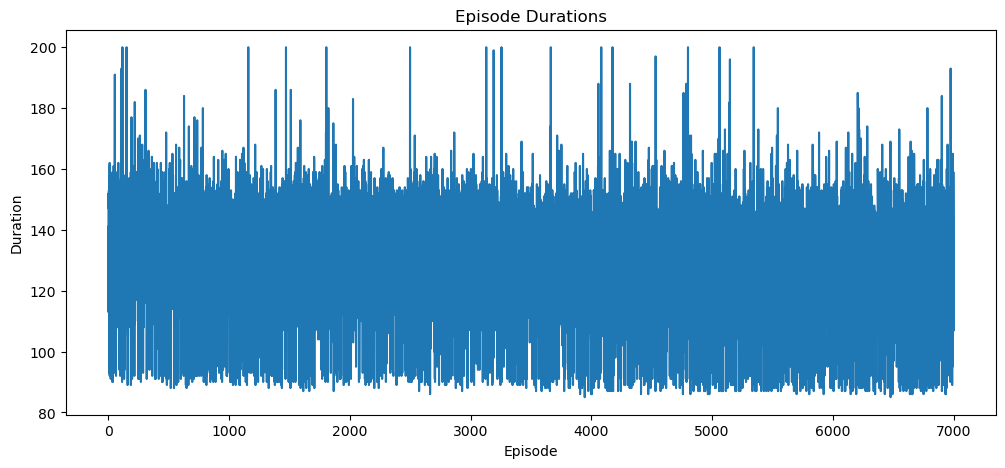

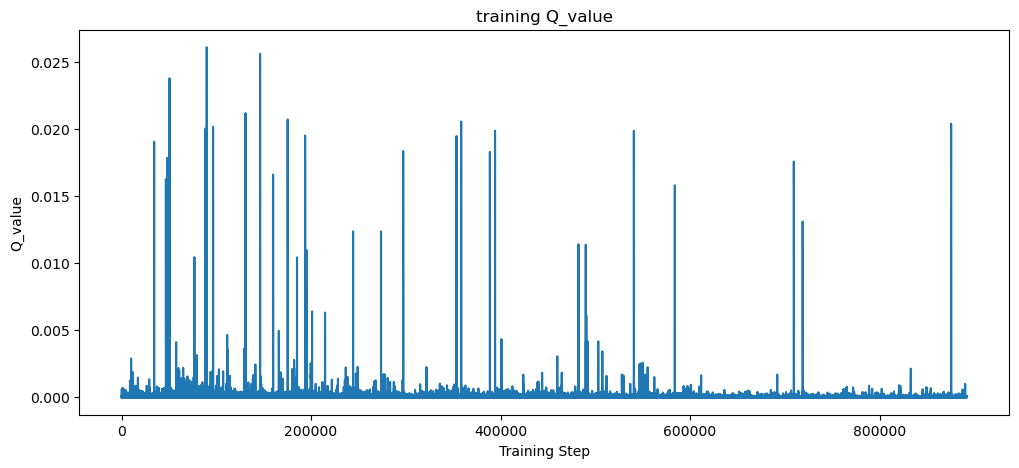

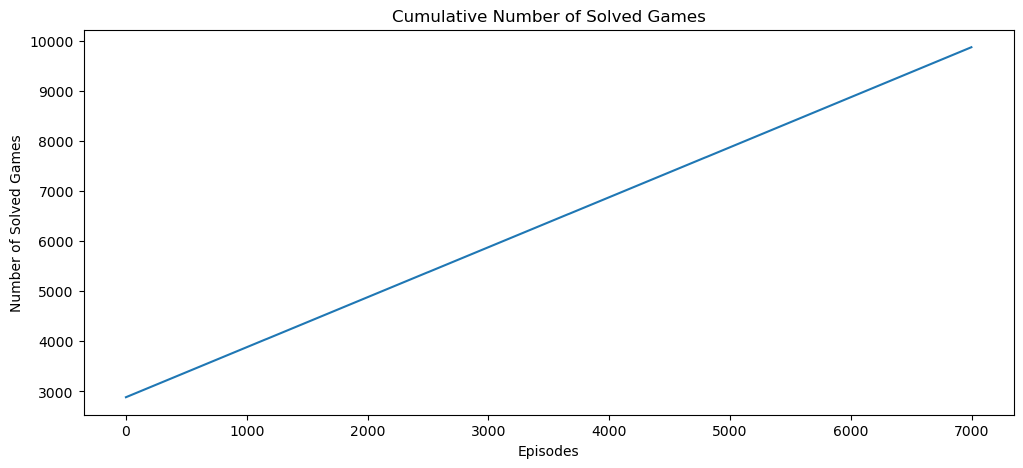

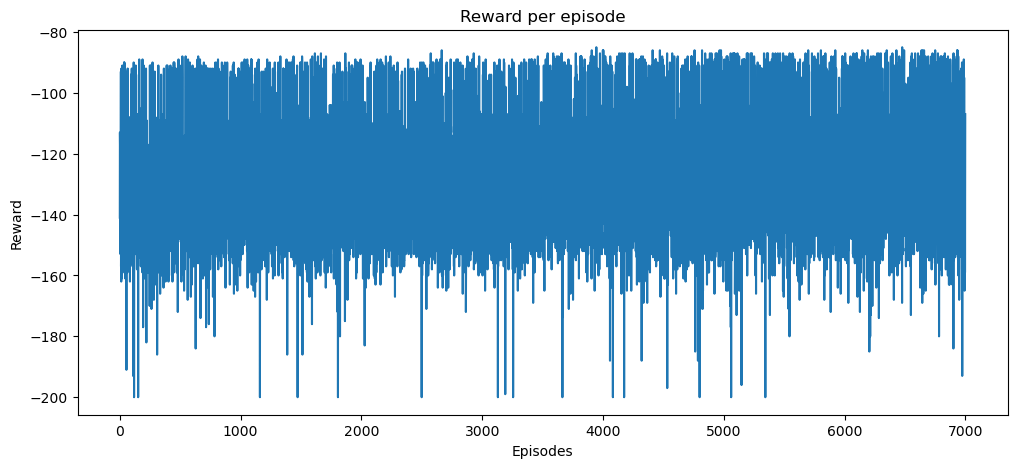

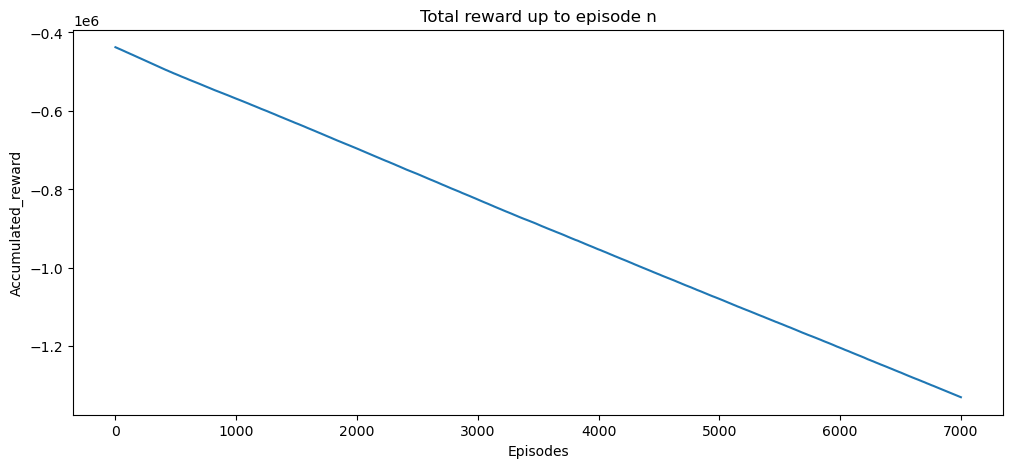

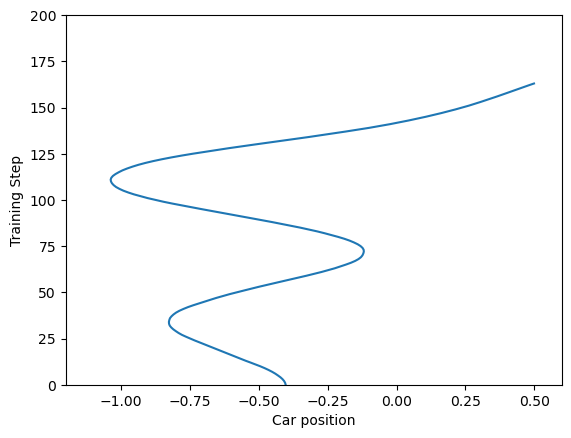

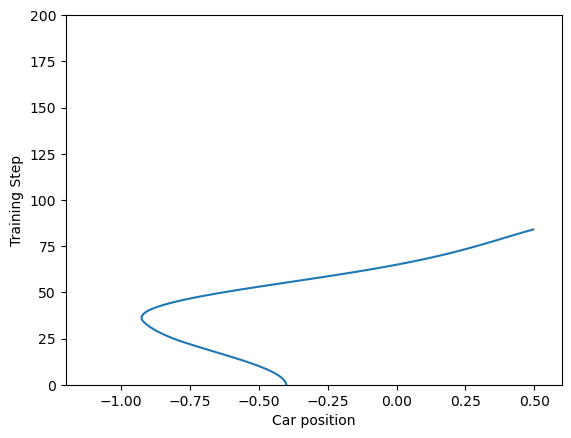

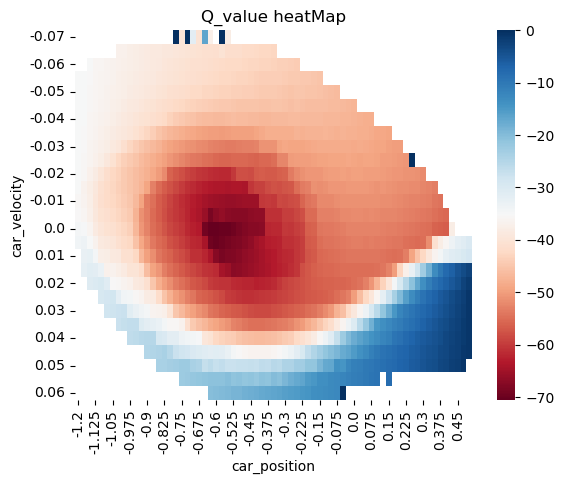

In [11]:
scores, eps_history, solved_count_history, accumulated_reward_per_ep, total_reward_up_to_n, Qval = [], [], [], [], [], []
n_games = 7000

for i in range(n_games):
    steps, total_reward, done = 0, 0, False
    observation, _ = env.reset()
    imgTemp = []
    while not done:
        imgTemp += [observation[0]]
        action = dynaAgSave.select_action(observation)
        observation_, reward, terminated, truncated, _ = env.step(action)
        steps += 1
        done = terminated or truncated
        Qval += [dynaAgSave.observe(observation, action, observation_, reward)]
        observation = observation_
        total_reward += reward
        total_reward_up_to_now += reward

    scores.append(steps)
    accumulated_reward_per_ep.append(total_reward)
    total_reward_up_to_n.append(total_reward_up_to_now)
    if steps < 200:
        solved_games += 1
        if smallest == 200:
            imgs[0] = imgTemp
            smallest = steps
        if steps < smallest:
            imgs[1] = imgTemp
            smallest = steps

    solved_count_history.append(solved_games)

    avg_score = np.mean(scores[-100:])
    print('Episode ', i, 'score: %.2f' % steps, 'average score: %.2f' % avg_score, 'epsilon: %.2f' % dynaAgSave.e[0])

# Visualization of Results
plt.figure(figsize=(12, 5))
plt.plot(scores)
plt.title('Episode Durations')
plt.xlabel('Episode')
plt.ylabel('Duration')
plt.show()

plt.figure(figsize=(12, 5))
plt.plot(Qval)
plt.title('training Q_value')
plt.xlabel('Training Step')
plt.ylabel('Q_value')
plt.show()

plt.figure(figsize=(12, 5))
plt.plot(solved_count_history)
plt.title('Cumulative Number of Solved Games')
plt.xlabel('Episodes')
plt.ylabel('Number of Solved Games')
plt.show()

plt.figure(figsize=(12, 5))
plt.plot(accumulated_reward_per_ep)
plt.title('Reward per episode')
plt.xlabel('Episodes')
plt.ylabel('Reward')
plt.show()

plt.figure(figsize=(12, 5))
plt.plot(total_reward_up_to_n)
plt.title('Total reward up to episode n')
plt.xlabel('Episodes')
plt.ylabel('Accumulated_reward')
plt.show()

for img in imgs:
    ax = plt.gca()
    ax.plot(img)
    ax.set_xlim([env.observation_space.low[0], env.observation_space.high[0]])
    ax.set_ylim([0, 200])
    newx = ax.lines[0].get_ydata()
    newy = ax.lines[0].get_xdata()

    # set new x- and y- data for the line
    ax.lines[0].set_xdata(newx)
    ax.lines[0].set_ydata(newy)
    plt.ylabel('Training Step')
    plt.xlabel('Car position')
    plt.show()
    
xs = []
ys = []
Qs = []
seen = []

for k in dynaAgSave.P_opti.keys():
    if (k[0], k[1]) in seen:
        continue
        
    seen += [(k[0], k[1])]
    xs += [k[0]]
    ys += [k[1]]
    
    maxElem = dynaAgSave.Q[(k[0], k[1], dynaAgSave.listOfAction[0])]
    for actionIter in dynaAgSave.listOfAction[1:]:
        elem = dynaAgSave.Q[(k[0], k[1], actionIter)]
        if elem > maxElem:
            maxElem = elem
    Qs += [maxElem]

df = pd.DataFrame.from_dict(np.array([xs,ys,Qs]).T)
df.columns = ['car_position','car_velocity','max_Q_value']
df['Z_value'] = pd.to_numeric(df['max_Q_value'])
pivotted= df.pivot(index='car_velocity', columns='car_position', values='max_Q_value')
ax = sns.heatmap(pivotted,cmap='RdBu')
plt.title('Q_value heatMap')
plt.show()

with open('DynaModel10000.pkl', 'wb') as outp:
    pickle.dump(dynaAgSave, outp, pickle.HIGHEST_PROTOCOL)

Test for big discretization size

Episode  0 score: 200.00 average score: 200.00 epsilon: 0.86
Episode  1 score: 200.00 average score: 200.00 epsilon: 0.83
Episode  2 score: 200.00 average score: 200.00 epsilon: 0.80
Episode  3 score: 200.00 average score: 200.00 epsilon: 0.77
Episode  4 score: 200.00 average score: 200.00 epsilon: 0.74
Episode  5 score: 200.00 average score: 200.00 epsilon: 0.71
Episode  6 score: 200.00 average score: 200.00 epsilon: 0.68
Episode  7 score: 200.00 average score: 200.00 epsilon: 0.65
Episode  8 score: 200.00 average score: 200.00 epsilon: 0.63
Episode  9 score: 200.00 average score: 200.00 epsilon: 0.60
Episode  10 score: 200.00 average score: 200.00 epsilon: 0.58
Episode  11 score: 200.00 average score: 200.00 epsilon: 0.56
Episode  12 score: 200.00 average score: 200.00 epsilon: 0.54
Episode  13 score: 200.00 average score: 200.00 epsilon: 0.51
Episode  14 score: 200.00 average score: 200.00 epsilon: 0.49
Episode  15 score: 200.00 average score: 200.00 epsilon: 0.47
Episode  16 score:

Episode  132 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  133 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  134 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  135 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  136 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  137 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  138 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  139 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  140 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  141 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  142 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  143 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  144 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  145 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  146 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  147 score: 200.00 average score: 200.00 epsilo

Episode  263 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  264 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  265 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  266 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  267 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  268 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  269 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  270 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  271 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  272 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  273 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  274 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  275 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  276 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  277 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  278 score: 200.00 average score: 200.00 epsilo

Episode  394 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  395 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  396 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  397 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  398 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  399 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  400 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  401 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  402 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  403 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  404 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  405 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  406 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  407 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  408 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  409 score: 200.00 average score: 200.00 epsilo

Episode  525 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  526 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  527 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  528 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  529 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  530 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  531 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  532 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  533 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  534 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  535 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  536 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  537 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  538 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  539 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  540 score: 200.00 average score: 200.00 epsilo

Episode  656 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  657 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  658 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  659 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  660 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  661 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  662 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  663 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  664 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  665 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  666 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  667 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  668 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  669 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  670 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  671 score: 200.00 average score: 200.00 epsilo

Episode  787 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  788 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  789 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  790 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  791 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  792 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  793 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  794 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  795 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  796 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  797 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  798 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  799 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  800 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  801 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  802 score: 200.00 average score: 200.00 epsilo

Episode  918 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  919 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  920 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  921 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  922 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  923 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  924 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  925 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  926 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  927 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  928 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  929 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  930 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  931 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  932 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  933 score: 200.00 average score: 200.00 epsilo

Episode  1048 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  1049 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  1050 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  1051 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  1052 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  1053 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  1054 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  1055 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  1056 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  1057 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  1058 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  1059 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  1060 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  1061 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  1062 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  1063 score: 200.00 average scor

Episode  1177 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  1178 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  1179 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  1180 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  1181 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  1182 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  1183 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  1184 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  1185 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  1186 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  1187 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  1188 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  1189 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  1190 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  1191 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  1192 score: 200.00 average scor

Episode  1306 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  1307 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  1308 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  1309 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  1310 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  1311 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  1312 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  1313 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  1314 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  1315 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  1316 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  1317 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  1318 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  1319 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  1320 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  1321 score: 200.00 average scor

Episode  1435 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  1436 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  1437 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  1438 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  1439 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  1440 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  1441 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  1442 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  1443 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  1444 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  1445 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  1446 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  1447 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  1448 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  1449 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  1450 score: 200.00 average scor

Episode  1564 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  1565 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  1566 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  1567 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  1568 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  1569 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  1570 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  1571 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  1572 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  1573 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  1574 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  1575 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  1576 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  1577 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  1578 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  1579 score: 200.00 average scor

Episode  1693 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  1694 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  1695 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  1696 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  1697 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  1698 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  1699 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  1700 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  1701 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  1702 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  1703 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  1704 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  1705 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  1706 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  1707 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  1708 score: 200.00 average scor

Episode  1822 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  1823 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  1824 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  1825 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  1826 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  1827 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  1828 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  1829 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  1830 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  1831 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  1832 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  1833 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  1834 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  1835 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  1836 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  1837 score: 200.00 average scor

Episode  1951 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  1952 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  1953 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  1954 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  1955 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  1956 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  1957 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  1958 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  1959 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  1960 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  1961 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  1962 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  1963 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  1964 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  1965 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  1966 score: 200.00 average scor

Episode  2080 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  2081 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  2082 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  2083 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  2084 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  2085 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  2086 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  2087 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  2088 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  2089 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  2090 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  2091 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  2092 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  2093 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  2094 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  2095 score: 200.00 average scor

Episode  2209 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  2210 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  2211 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  2212 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  2213 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  2214 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  2215 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  2216 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  2217 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  2218 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  2219 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  2220 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  2221 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  2222 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  2223 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  2224 score: 200.00 average scor

Episode  2338 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  2339 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  2340 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  2341 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  2342 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  2343 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  2344 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  2345 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  2346 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  2347 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  2348 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  2349 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  2350 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  2351 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  2352 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  2353 score: 200.00 average scor

Episode  2467 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  2468 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  2469 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  2470 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  2471 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  2472 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  2473 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  2474 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  2475 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  2476 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  2477 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  2478 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  2479 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  2480 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  2481 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  2482 score: 200.00 average scor

Episode  2596 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  2597 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  2598 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  2599 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  2600 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  2601 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  2602 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  2603 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  2604 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  2605 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  2606 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  2607 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  2608 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  2609 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  2610 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  2611 score: 200.00 average scor

Episode  2725 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  2726 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  2727 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  2728 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  2729 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  2730 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  2731 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  2732 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  2733 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  2734 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  2735 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  2736 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  2737 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  2738 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  2739 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  2740 score: 200.00 average scor

Episode  2854 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  2855 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  2856 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  2857 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  2858 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  2859 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  2860 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  2861 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  2862 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  2863 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  2864 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  2865 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  2866 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  2867 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  2868 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  2869 score: 200.00 average scor

Episode  2983 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  2984 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  2985 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  2986 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  2987 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  2988 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  2989 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  2990 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  2991 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  2992 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  2993 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  2994 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  2995 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  2996 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  2997 score: 200.00 average score: 200.00 epsilon: 0.05
Episode  2998 score: 200.00 average scor

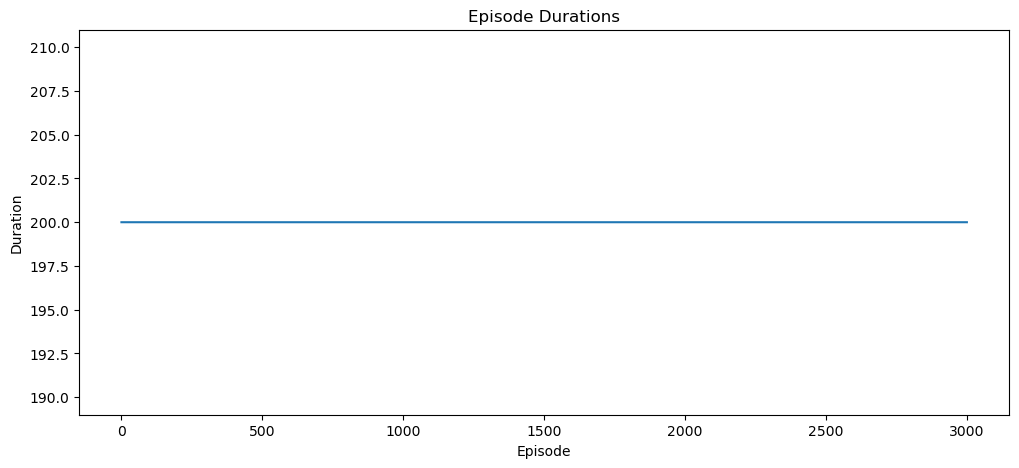

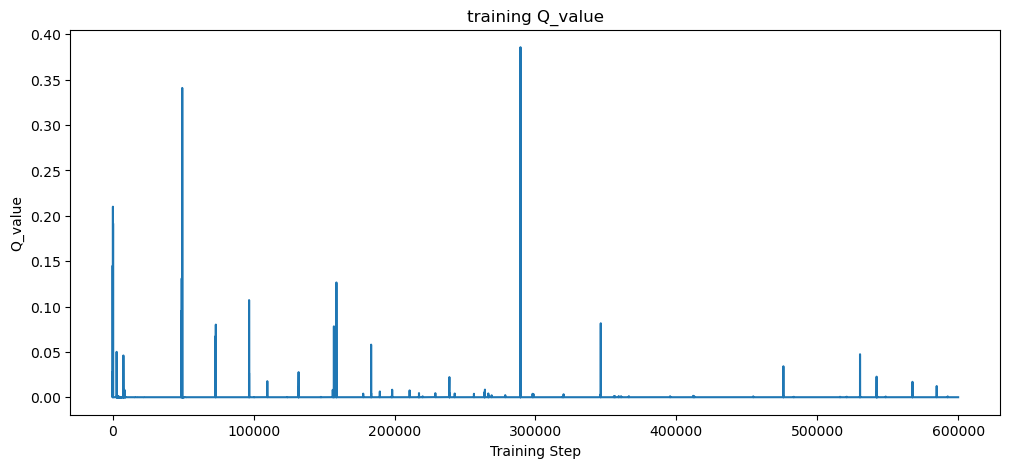

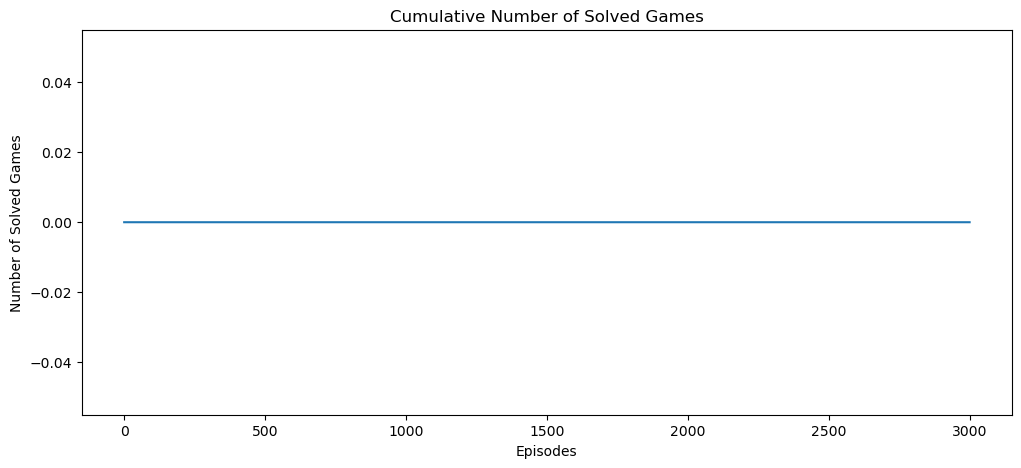

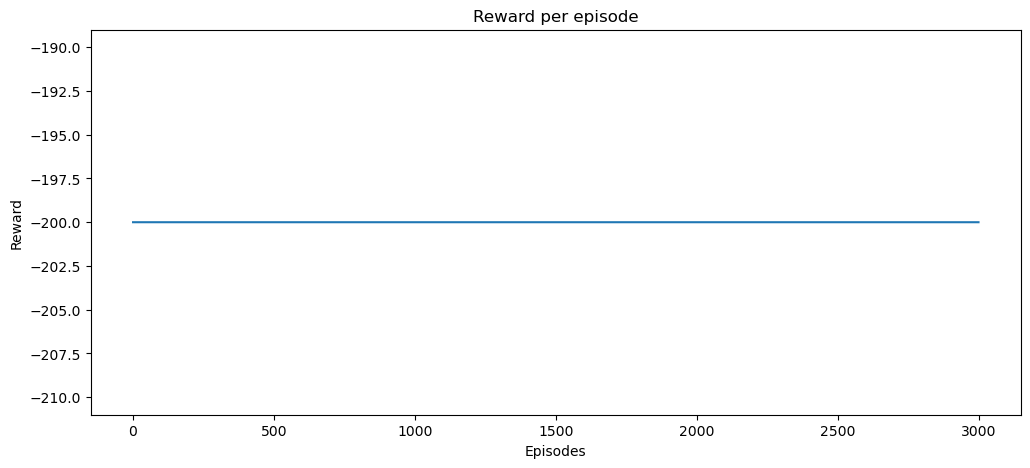

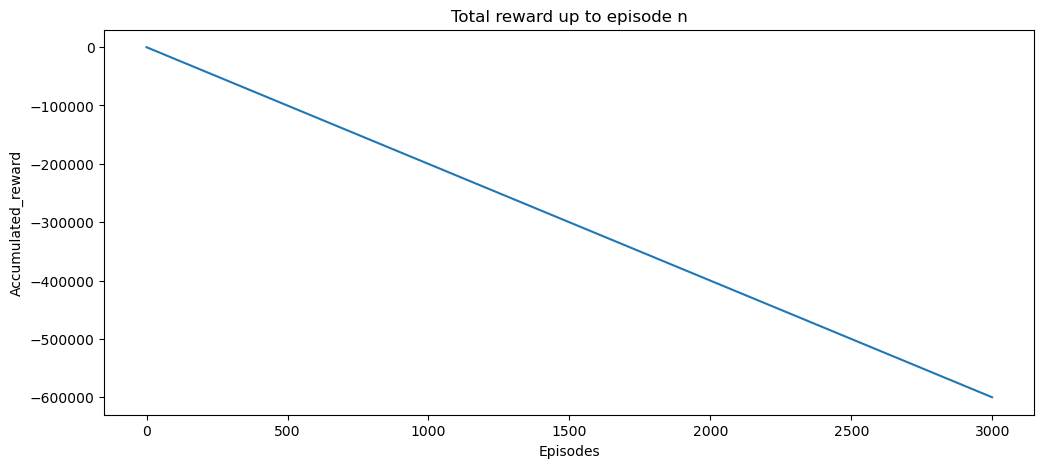

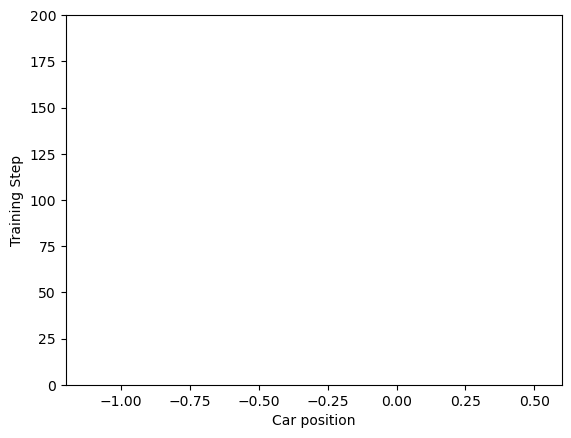

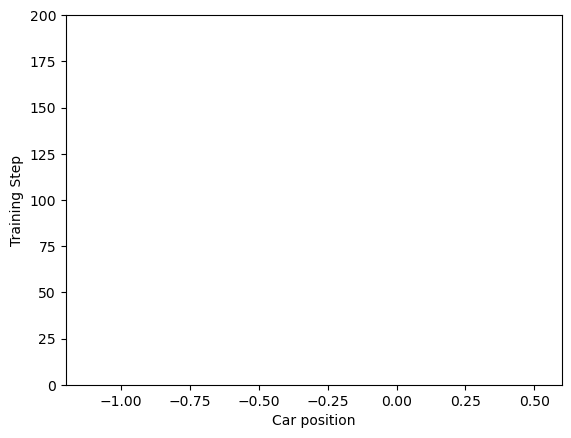

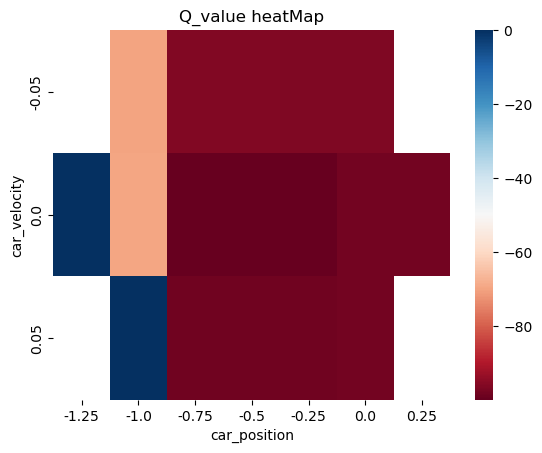

In [12]:
dynaAgBig = dynaAgent([0.25,0.050], 0.99, [0.9, 0.05], 2000)

scores, eps_history, solved_count_history, accumulated_reward_per_ep, total_reward_up_to_n, Qval = [], [], [], [], [], []
n_games = 3000
solved_games = 0  # Counter for the number of games solved
total_reward_up_to_now = 0
imgs = [[], []]
smallest = 200

for i in range(n_games):
    steps, total_reward, done = 0, 0, False
    observation, _ = env.reset()
    imgTemp = []
    while not done:
        imgTemp += [observation[0]]
        action = dynaAgBig.select_action(observation)
        observation_, reward, terminated, truncated, _ = env.step(action)
        steps += 1
        done = terminated or truncated
        Qval += [dynaAgBig.observe(observation, action, observation_, reward)]
        observation = observation_
        total_reward += reward
        total_reward_up_to_now += reward

    scores.append(steps)
    accumulated_reward_per_ep.append(total_reward)
    total_reward_up_to_n.append(total_reward_up_to_now)
    if steps < 200:
        solved_games += 1
        if smallest == 200:
            imgs[0] = imgTemp
            smallest = steps
        if steps < smallest:
            imgs[1] = imgTemp
            smallest = steps

    solved_count_history.append(solved_games)

    avg_score = np.mean(scores[-100:])
    print('Episode ', i, 'score: %.2f' % steps, 'average score: %.2f' % avg_score, 'epsilon: %.2f' % dynaAgBig.e[0])

# Visualization of Results
plt.figure(figsize=(12, 5))
plt.plot(scores)
plt.title('Episode Durations')
plt.xlabel('Episode')
plt.ylabel('Duration')
plt.show()

plt.figure(figsize=(12, 5))
plt.plot(Qval)
plt.title('training Q_value')
plt.xlabel('Training Step')
plt.ylabel('Q_value')
plt.show()

plt.figure(figsize=(12, 5))
plt.plot(solved_count_history)
plt.title('Cumulative Number of Solved Games')
plt.xlabel('Episodes')
plt.ylabel('Number of Solved Games')
plt.show()

plt.figure(figsize=(12, 5))
plt.plot(accumulated_reward_per_ep)
plt.title('Reward per episode')
plt.xlabel('Episodes')
plt.ylabel('Reward')
plt.show()

plt.figure(figsize=(12, 5))
plt.plot(total_reward_up_to_n)
plt.title('Total reward up to episode n')
plt.xlabel('Episodes')
plt.ylabel('Accumulated_reward')
plt.show()

for img in imgs:
    ax = plt.gca()
    ax.plot(img)
    ax.set_xlim([env.observation_space.low[0], env.observation_space.high[0]])
    ax.set_ylim([0, 200])
    newx = ax.lines[0].get_ydata()
    newy = ax.lines[0].get_xdata()

    # set new x- and y- data for the line
    ax.lines[0].set_xdata(newx)
    ax.lines[0].set_ydata(newy)
    plt.ylabel('Training Step')
    plt.xlabel('Car position')
    plt.show()
    
xs = []
ys = []
Qs = []
seen = []

for k in dynaAgBig.P_opti.keys():
    if (k[0], k[1]) in seen:
        continue
        
    seen += [(k[0], k[1])]
    xs += [k[0]]
    ys += [k[1]]
    
    maxElem = dynaAgBig.Q[(k[0], k[1], dynaAgBig.listOfAction[0])]
    for actionIter in dynaAgBig.listOfAction[1:]:
        elem = dynaAgBig.Q[(k[0], k[1], actionIter)]
        if elem > maxElem:
            maxElem = elem
    Qs += [maxElem]

df = pd.DataFrame.from_dict(np.array([xs,ys,Qs]).T)
df.columns = ['car_position','car_velocity','max_Q_value']
df['Z_value'] = pd.to_numeric(df['max_Q_value'])
pivotted= df.pivot(index='car_velocity', columns='car_position', values='max_Q_value')
ax = sns.heatmap(pivotted,cmap='RdBu')
plt.title('Q_value heatMap')
plt.show()

Test duration of small discretization

In [24]:
dynaAgTest1 = dynaAgent([0.0125,0.0025], 0.99, [0.9, 0.05], 2000)
dynaAgTest2 = dynaAgent([0.025,0.0050], 0.99, [0.9, 0.05], 2000)
n_games = 100

timeStart = time.time()

for i in range(n_games):
    while not done:
        action = dynaAgTest1.select_action(observation)
        observation_, reward, terminated, truncated, _ = env.step(action)
        steps += 1
        done = terminated or truncated
        dynaAgTest1.observe(observation, action, observation_, reward)
        observation = observation_
timeEnd = time.time()

timeStart2 = time.time()
for i in range(n_games):
    while not done:
        action = dynaAgTest2.select_action(observation)
        observation_, reward, terminated, truncated, _ = env.step(action)
        steps += 1
        done = terminated or truncated
        dynaAgTest2.observe(observation, action, observation_, reward)
        observation = observation_
timeEnd2 = time.time()

print("time needed for small values : " + str((timeEnd-timeStart)))
print("time needed for normal values : " + str((timeEnd2-timeStart2)))

time needed for small values : 7.271766662597656e-05
time needed for normal values : 4.506111145019531e-05


Play with the size of the discretization steps. What happens if you use overly large bins? On
the other hand, why would we refrain from using too small bins? Give an intuitive explanation,
backed up by experimental results.

Too big of a size make it less efficient as change in the state of the environment is less represented in the agent training leading to a worse training.
Too small of a size make the training either slow down or crash.

Try to understand why the DynaAgent manages to solve the task even without any auxiliary
reward. Explain your reasoning.

The inate way dynaAgent calculate the Q-value make it go smaller and smaller as long as this path don't lead to the sucess. This make it such that the code will naturally tend to explore the possibility until one solve the problem.



[[], [-0.47553855, -0.47689775, -0.47960606, -0.48364338, -0.48797962, -0.49358252, -0.5004102, -0.5084117, -0.51752704, -0.5276879, -0.5388181, -0.55083424, -0.5636463, -0.57715875, -0.59027123, -0.60388696, -0.61790633, -0.63222784, -0.6467489, -0.6613673, -0.6759815, -0.69049233, -0.70480305, -0.7188207, -0.7304564, -0.7416384, -0.75229925, -0.7623763, -0.7708118, -0.7765585, -0.781585, -0.785864, -0.7893728, -0.7900929, -0.7880205, -0.78516644, -0.7795459, -0.77118886, -0.760141, -0.7474643, -0.73423195, -0.71852297, -0.7004339, -0.68007994, -0.657595, -0.6331319, -0.60786206, -0.58096695, -0.55264366, -0.5231029, -0.49356574, -0.46425357, -0.43438417, -0.4041759, -0.37384427, -0.34359837, -0.31363782, -0.28614992, -0.25929603, -0.23422314, -0.21005805, -0.18791276, -0.16688064, -0.14904171, -0.132457, -0.119177505, -0.10923992, -0.101669274, -0.09748325, -0.09569106, -0.09729657, -0.102296345, -0.110679306, -0.12142572, -0.13450809, -0.15088965, -0.16951944, -0.19133283, -0.216245

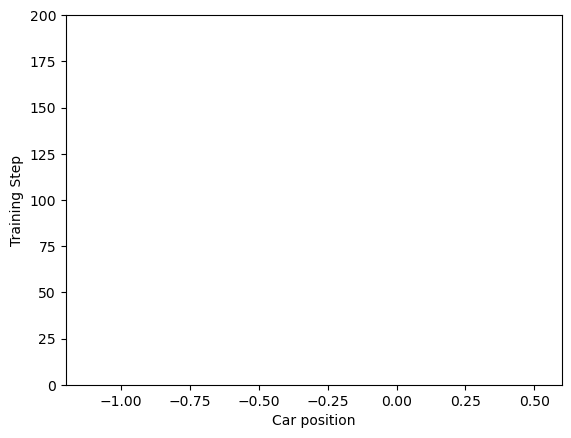

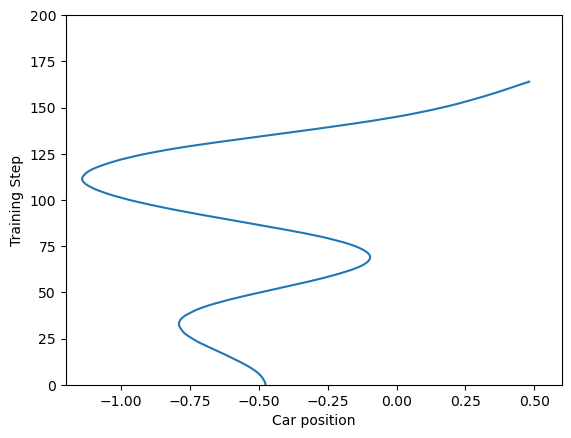

In [104]:
with open('DynaModel.pkl', 'rb') as inp:
    dynaAg = pickle.load(inp)

xs = []
ys = []
Qs = []
seen = []

for k in dynaAg.P_opti.keys():
    if (k[0], k[1]) in seen:
        continue
        
    seen += [(k[0], k[1])]
    xs += [k[0]]
    ys += [k[1]]
    
    maxElem = dynaAg.Q[(k[0], k[1], dynaAg.listOfAction[0])]
    for actionIter in dynaAg.listOfAction[1:]:
        elem = dynaAg.Q[(k[0], k[1], actionIter)]
        if elem > maxElem:
            maxElem = elem
    Qs += [maxElem]


fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(xs, Qs, ys)
plt.title('Q_value graph')
plt.show()

df = pd.DataFrame.from_dict(np.array([xs,ys,Qs]).T)
df.columns = ['car_position','car_velocity','max_Q_value']
df['Z_value'] = pd.to_numeric(df['max_Q_value'])
pivotted= df.pivot(index='car_velocity', columns='car_position', values='max_Q_value')
ax = sns.heatmap(pivotted,cmap='RdBu')
plt.title('Q_value heatMap')
plt.show()
